In [1]:
import pandas as pd
import sys
from pathlib import Path
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sys.path.append(str(Path.cwd().parent.parent / "src")) # Necessário contar quantos niveis subir nas pastas, incluir 1 .parent para cada nivel.

# My custom functions and classes
from utils.paths import resolve_env_path, PROJECT_ROOT
from classes.time_series_dataset import TimeSeriesDataset
from classes.plotter import Plotter
from utils.calculations import plot_stl_decomposition
from utils.calculations import process_df

In [2]:
ARRIVALS_PATH = resolve_env_path("ARRIVALS_PATH")
arrivals_dataset = TimeSeriesDataset(ARRIVALS_PATH)

## Missing Values Analysis - Rio de Janeiro Only

In [3]:
# Filter for Rio de Janeiro ONLY
df_complete = arrivals_dataset.data  # All data
df_complete_rj = df_complete[df_complete['state'] == 'rio_de_janeiro'].copy()

# df_clean = arrivals_dataset.get_data_without_missing_values()
# df_clean_rj = df_clean[df_clean['state'] == 'rio_de_janeiro'].copy()

print("=== Dataset Comparison - Rio de Janeiro ===")
print(f"Complete dataset (RJ): {len(df_complete_rj):,} rows")
# print(f"Clean dataset (RJ, no missing): {len(df_clean_rj):,} rows")
# print(f"Rows removed: {len(df_complete_rj) - len(df_clean_rj):,} ({(len(df_complete_rj) - len(df_clean_rj))/len(df_complete_rj)*100:.2f}%)")

print("\n=== Missing Values by Column (Rio de Janeiro) ===")
missing_summary = pd.DataFrame({
    'Missing_Count': df_complete_rj.isna().sum(),
    'Missing_Percentage': (df_complete_rj.isna().sum() / len(df_complete_rj) * 100).round(2)
}).sort_values('Missing_Count', ascending=False)
print(missing_summary[missing_summary['Missing_Count'] > 0])

print("\n=== Missing Values by Year (Rio de Janeiro) ===")
if 'year' in df_complete_rj.columns:
    missing_by_year = df_complete_rj.groupby('year')['arrivals'].apply(
        lambda x: x.isna().sum()
    ).sort_index()
    print(missing_by_year[missing_by_year > 0])

=== Dataset Comparison - Rio de Janeiro ===
Complete dataset (RJ): 42,689 rows

=== Missing Values by Column (Rio de Janeiro) ===
          Missing_Count  Missing_Percentage
arrivals            264                0.62

=== Missing Values by Year (Rio de Janeiro) ===
year
2004    120
2007    144
Name: arrivals, dtype: int64


In [4]:
## Check for Zero and Null Values by Date and Continent (Rio de Janeiro)

print("=== Checking for Null and Zero Arrivals by Date and Continent (RJ) ===\n")

# Filter for Rio de Janeiro only
df_rj_check = df_complete[df_complete['state'] == 'rio_de_janeiro'].copy()

# 1. Check for NULL values in arrivals by continent
print("1. NULL VALUES BY CONTINENT:")
print("-" * 80)
null_by_continent = df_rj_check.groupby('continent')['arrivals'].apply(
    lambda x: x.isna().sum()
).sort_values(ascending=False)
print(null_by_continent[null_by_continent > 0])
if null_by_continent.sum() == 0:
    print("✓ No null values found in arrivals column")

# 2. Check for ZERO values in arrivals by continent
print("\n2. ZERO VALUES BY CONTINENT:")
print("-" * 80)
zero_by_continent = df_rj_check.groupby('continent')['arrivals'].apply(
    lambda x: (x == 0).sum()
).sort_values(ascending=False)
print(zero_by_continent)

# 3. Combined: Null OR Zero by continent
print("\n3. NULL OR ZERO VALUES BY CONTINENT:")
print("-" * 80)
null_or_zero = df_rj_check.groupby('continent')['arrivals'].apply(
    lambda x: (x.isna() | (x == 0)).sum()
).sort_values(ascending=False)
for continent, count in null_or_zero.items():
    total_records = len(df_rj_check[df_rj_check['continent'] == continent])
    pct = (count / total_records * 100) if total_records > 0 else 0
    print(f"{continent:<25} {count:>6} / {total_records:<6} ({pct:>5.2f}%)")

# 4. Detailed analysis: Show specific dates with null or zero by continent
print("\n4. DATES WITH NULL OR ZERO VALUES BY CONTINENT:")
print("=" * 80)

for continent in sorted(df_rj_check['continent'].unique()):
    continent_data = df_rj_check[df_rj_check['continent'] == continent].copy()
    
    # Find null or zero values
    problematic = continent_data[
        continent_data['arrivals'].isna() | (continent_data['arrivals'] == 0)
    ].copy()
    
    if len(problematic) > 0:
        print(f"\n{continent.upper()}:")
        print("-" * 80)
        print(f"Total problematic records: {len(problematic)}")
        
        # Group by date to see which dates are affected
        dates_affected = problematic.groupby('date').agg({
            'arrivals': ['count', lambda x: x.isna().sum(), lambda x: (x == 0).sum()]
        })
        dates_affected.columns = ['total_records', 'null_count', 'zero_count']
        
        print(f"\nDates affected: {len(dates_affected)}")
        print(f"Date range: {problematic['date'].min()} to {problematic['date'].max()}")
        
        # Show first 5 examples
        print(f"\nFirst 5 examples:")
        print(problematic[['date', 'entry_route', 'arrivals']].head(5).to_string(index=False))
        
        # Check if it's a pattern (all zeros or all nulls in certain periods)
        if problematic['arrivals'].isna().all():
            print("⚠️  ALL values are NULL for these dates")
        elif (problematic['arrivals'] == 0).all():
            print("⚠️  ALL values are ZERO for these dates")

# 5. Timeline visualization of problematic values
print("\n5. TIMELINE OF NULL/ZERO VALUES:")
print("=" * 80)

# Create a pivot to see pattern by year and continent
df_rj_check['year'] = pd.to_datetime(df_rj_check['date']).dt.year
pivot_null_zero = df_rj_check.groupby(['year', 'continent']).apply(
    lambda x: (x['arrivals'].isna() | (x['arrivals'] == 0)).sum()
).unstack(fill_value=0)

if not pivot_null_zero.empty:
    print("\nNull/Zero count by Year and Continent:")
    print(pivot_null_zero)
else:
    print("✓ No null or zero values found across years and continents")

# 6. Summary statistics
print("\n6. SUMMARY:")
print("=" * 80)
total_records_rj = len(df_rj_check)
total_null = df_rj_check['arrivals'].isna().sum()
total_zero = (df_rj_check['arrivals'] == 0).sum()
total_problematic = (df_rj_check['arrivals'].isna() | (df_rj_check['arrivals'] == 0)).sum()

print(f"Total records (RJ): {total_records_rj:,}")
print(f"Null values: {total_null:,} ({total_null/total_records_rj*100:.2f}%)")
print(f"Zero values: {total_zero:,} ({total_zero/total_records_rj*100:.2f}%)")
print(f"Null OR Zero: {total_problematic:,} ({total_problematic/total_records_rj*100:.2f}%)")
print(f"Clean records: {total_records_rj - total_problematic:,} ({(total_records_rj - total_problematic)/total_records_rj*100:.2f}%)")

=== Checking for Null and Zero Arrivals by Date and Continent (RJ) ===

1. NULL VALUES BY CONTINENT:
--------------------------------------------------------------------------------
continent
europa                      144
america_central_e_caribe     48
asia                         24
africa                       24
oceania                      24
Name: arrivals, dtype: int64

2. ZERO VALUES BY CONTINENT:
--------------------------------------------------------------------------------
continent
europa                         3678
america_do_sul                 2799
asia                           2621
africa                         1941
america_central_e_caribe       1685
oceania                         549
america_do_norte                357
continente_nao_especificado     279
Name: arrivals, dtype: int64

3. NULL OR ZERO VALUES BY CONTINENT:
--------------------------------------------------------------------------------
europa                      3822 / 15043  (25.41%)
america_do_

C:\Users\f0oo\AppData\Local\Temp\ipykernel_4404\4043702090.py:79: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pivot_null_zero = df_rj_check.groupby(['year', 'continent']).apply(


# Time Series Analysis by Continent

In [ ]:
# Load and prepare data
df = arrivals_dataset.get_data_without_missing_values()

# Process data for Rio de Janeiro with continent information
df_rj = process_df(
    df=df, 
    state="rio_de_janeiro", 
    agg_cols=["date", "continent"], 
    value_cols="arrivals", 
    agg_func="sum"
)

print(f"Dataset period: {df_rj['date'].min()} to {df_rj['date'].max()}")
print(f"Total observations: {len(df_rj)}")
print(f"Number of continents: {df_rj['continent'].nunique()}")
print(f"\nContinents: {df_rj['continent'].unique()}")
df_rj.head(10)

Dataset period: 2000-01-01 00:00:00 to 2024-12-01 00:00:00
Total observations: 2100
Number of continents: 7

Continents: ['africa' 'america_central_e_caribe' 'america_do_norte' 'america_do_sul'
 'asia' 'europa' 'oceania']


date                 continent  arrivals
0 2000-01-01                    africa    1667.0
1 2000-01-01  america_central_e_caribe     449.0
2 2000-01-01          america_do_norte   22202.0
3 2000-01-01            america_do_sul   22097.0
4 2000-01-01                      asia    2902.0
5 2000-01-01                    europa   41142.0
6 2000-01-01                   oceania     859.0
7 2000-02-01                    africa    1538.0
8 2000-02-01  america_central_e_caribe     385.0
9 2000-02-01          america_do_norte   19060.0

In [6]:
# Check for null and zero values in aggregated data
print("=== Verification after aggregation ===")
print(f"Null values in arrivals: {df_rj['arrivals'].isna().sum()}")
print(f"Zero values in arrivals: {(df_rj['arrivals'] == 0).sum()}")
print(f"Total records: {len(df_rj)}")

=== Verification after aggregation ===
Null values in arrivals: 0
Zero values in arrivals: 19
Total records: 2100


In [7]:
# Show rows with zero values
zero_rows = df_rj[df_rj['arrivals'] == 0]

if len(zero_rows) > 0:
    print(f"\n=== Rows with ZERO arrivals ({len(zero_rows)} rows) ===")
    print(zero_rows)
    
    print("\n=== Zero values by continent ===")
    print(zero_rows.groupby('continent').size())
    
    print("\n=== Date range of zeros ===")
    print(f"First zero: {zero_rows['date'].min()}")
    print(f"Last zero: {zero_rows['date'].max()}")
else:
    print("✓ No zero values found")


=== Rows with ZERO arrivals (19 rows) ===
           date                 continent  arrivals
1701 2020-04-01                    africa       0.0
1702 2020-04-01  america_central_e_caribe       0.0
1703 2020-04-01          america_do_norte       0.0
1704 2020-04-01            america_do_sul       0.0
1707 2020-04-01                   oceania       0.0
1708 2020-05-01                    africa       0.0
1709 2020-05-01  america_central_e_caribe       0.0
1710 2020-05-01          america_do_norte       0.0
1712 2020-05-01                      asia       0.0
1714 2020-05-01                   oceania       0.0
1715 2020-06-01                    africa       0.0
1716 2020-06-01  america_central_e_caribe       0.0
1718 2020-06-01            america_do_sul       0.0
1721 2020-06-01                   oceania       0.0
1722 2020-07-01                    africa       0.0
1723 2020-07-01  america_central_e_caribe       0.0
1728 2020-07-01                   oceania       0.0
1730 2020-08-01  amer

## Individual Time Series Plots by Continent

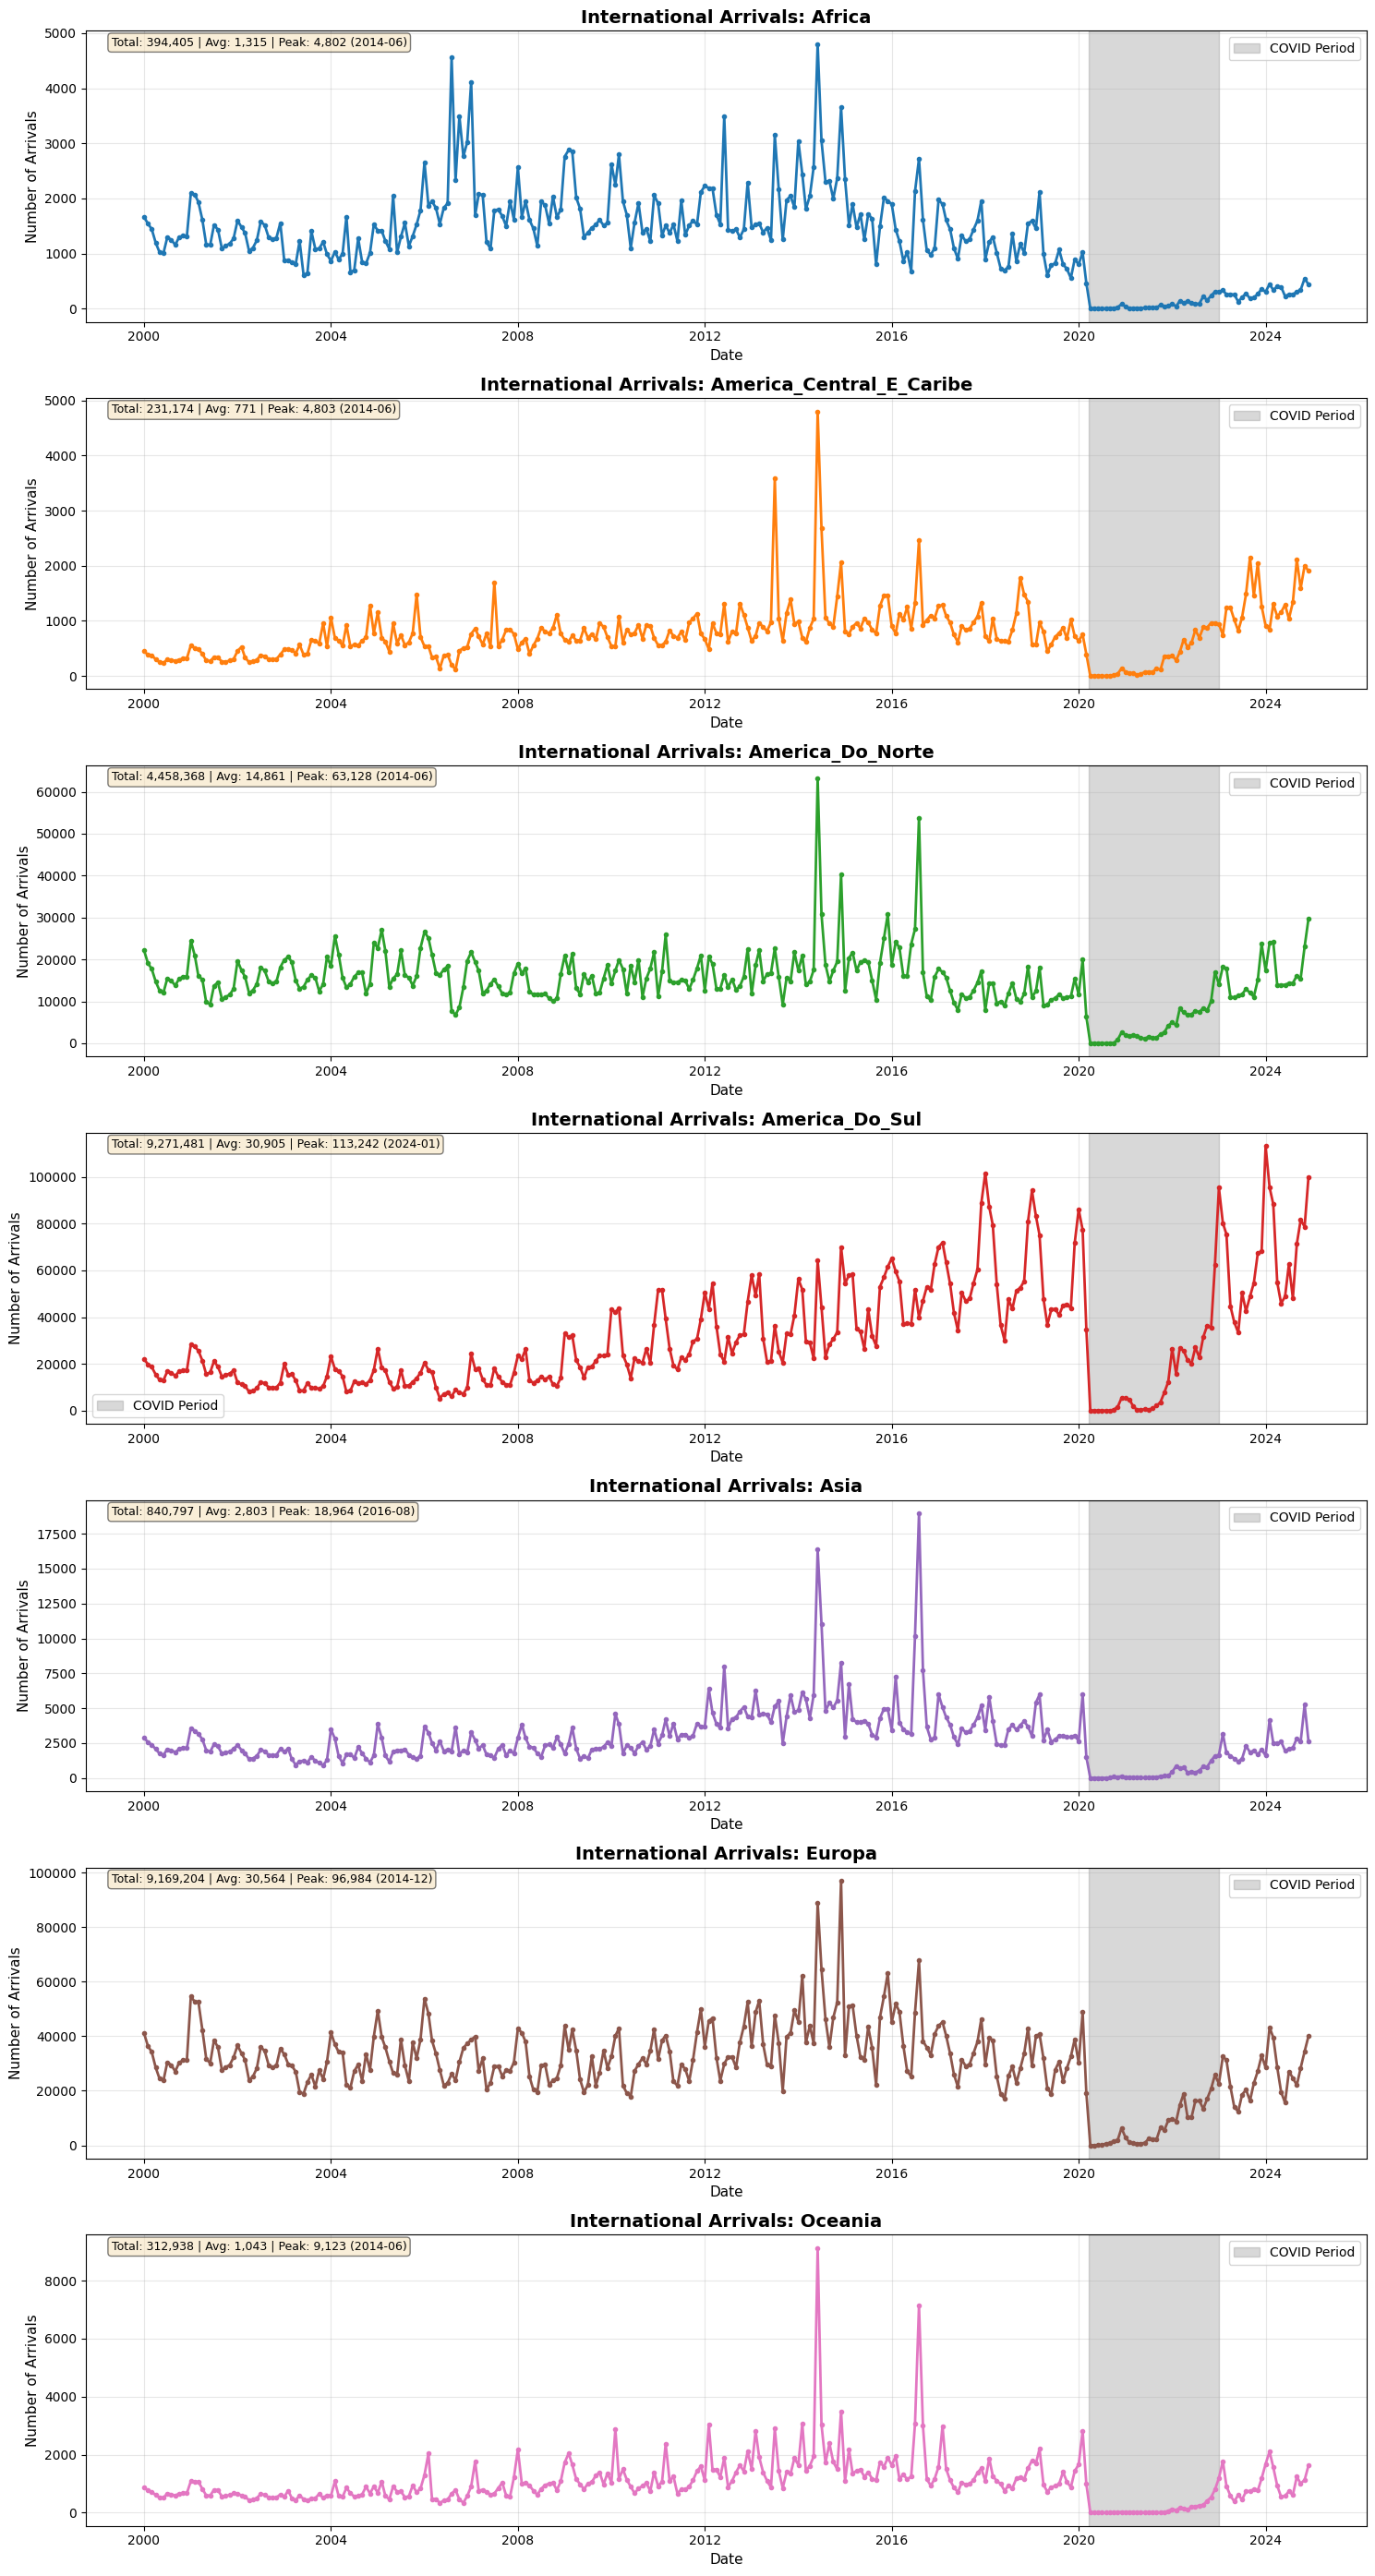


=== Summary Statistics by Continent ===
                              Total   Average   Median  Min       Max  \
continent                                                               
america_do_sul            9271481.0  30904.94  23485.0  0.0  113242.0   
europa                    9169204.0  30564.01  29828.0  6.0   96984.0   
america_do_norte          4458368.0  14861.23  14761.5  0.0   63128.0   
asia                       840797.0   2802.66   2375.0  0.0   18964.0   
africa                     394405.0   1314.68   1325.0  0.0    4802.0   
oceania                    312938.0   1043.13    900.5  0.0    9123.0   
america_central_e_caribe   231174.0    770.58    713.0  0.0    4803.0   

                               Std  
continent                           
america_do_sul            22911.90  
europa                    13478.73  
america_do_norte           6955.96  
asia                       2085.17  
africa                      815.25  
oceania                     869.69  
ameri

In [8]:
# Get unique continents
continents = sorted(df_rj['continent'].unique())
n_continents = len(continents)

# Create subplots - one for each continent
fig, axes = plt.subplots(n_continents, 1, figsize=(15, 4*n_continents))

# Ensure axes is always a list
if n_continents == 1:
    axes = [axes]

# Plot each continent
for i, continent in enumerate(continents):
    # Filter data for this continent
    continent_data = df_rj[df_rj['continent'] == continent].sort_values('date')
    
    # Plot
    axes[i].plot(continent_data['date'], continent_data['arrivals'], 
                linewidth=2, color=f'C{i}', marker='o', markersize=3)
    
    # Highlight COVID period
    covid_start = pd.Timestamp('2020-03-19')
    covid_end = pd.Timestamp('2022-12-31')
    axes[i].axvspan(covid_start, covid_end, alpha=0.3, color='gray', label='COVID Period')
    
    # Formatting
    axes[i].set_title(f'International Arrivals: {continent.title()}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Date', fontsize=11)
    axes[i].set_ylabel('Number of Arrivals', fontsize=11)
    axes[i].grid(True, alpha=0.3)
    axes[i].legend()
    
    # Calculate and display statistics
    total_arrivals = continent_data['arrivals'].sum()
    avg_arrivals = continent_data['arrivals'].mean()
    max_arrivals = continent_data['arrivals'].max()
    max_date = continent_data.loc[continent_data['arrivals'].idxmax(), 'date']
    
    # Add text with stats
    stats_text = f'Total: {total_arrivals:,.0f} | Avg: {avg_arrivals:,.0f} | Peak: {max_arrivals:,.0f} ({max_date.strftime("%Y-%m")})'
    axes[i].text(0.02, 0.98, stats_text, transform=axes[i].transAxes,
                fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== Summary Statistics by Continent ===")
summary = df_rj.groupby('continent')['arrivals'].agg([
    ('Total', 'sum'),
    ('Average', 'mean'),
    ('Median', 'median'),
    ('Min', 'min'),
    ('Max', 'max'),
    ('Std', 'std')
]).round(2)
print(summary.sort_values('Total', ascending=False))

## Comparative Time Series Plot - All Continents

In [9]:
# Comparative plot - all continents in one chart
fig, ax = plt.subplots(figsize=(16, 8))

for i, continent in enumerate(continents):
    continent_data = df_rj[df_rj['continent'] == continent].sort_values('date')
    ax.plot(continent_data['date'], continent_data['arrivals'], 
           linewidth=2.5, label=continent.title(), marker='o', markersize=2)

# Highlight COVID period
covid_start = pd.Timestamp('2020-03-19')
covid_end = pd.Timestamp('2022-12-31')
ax.axvspan(covid_start, covid_end, alpha=0.2, color='gray', label='COVID Period')

# Formatting
ax.set_title('International Arrivals to Rio de Janeiro by Continent', 
            fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Date', fontsize=13)
ax.set_ylabel('Number of Arrivals', fontsize=13)
ax.legend(loc='best', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')

# Set seaborn style
sns.set_palette("husl")

plt.tight_layout()
plt.show()

# Calculate percentage contribution by continent
print("\n=== Percentage Contribution by Continent ===")
total_by_continent = df_rj.groupby('continent')['arrivals'].sum()
total_overall = total_by_continent.sum()
percentage = (total_by_continent / total_overall * 100).sort_values(ascending=False)

for continent, pct in percentage.items():
    print(f"{continent.title():<20} {pct:>6.2f}%  {'█' * int(pct/2)}")


=== Percentage Contribution by Continent ===
America_Do_Sul        37.57%  ██████████████████
Europa                37.15%  ██████████████████
America_Do_Norte      18.07%  █████████
Asia                   3.41%  █
Africa                 1.60%  
Oceania                1.27%  
America_Central_E_Caribe   0.94%  


=== STL Decomposition - Pre-COVID Period ===
Period: 2000-01-01 00:00:00 to 2020-02-01 00:00:00
Total observations (pre-COVID): 1694



CONTINENT: AFRICA

Observations: 242
Period: 2000-01-01 00:00:00 to 2020-02-01 00:00:00
Mean arrivals: 1589.08
Std arrivals: 654.38




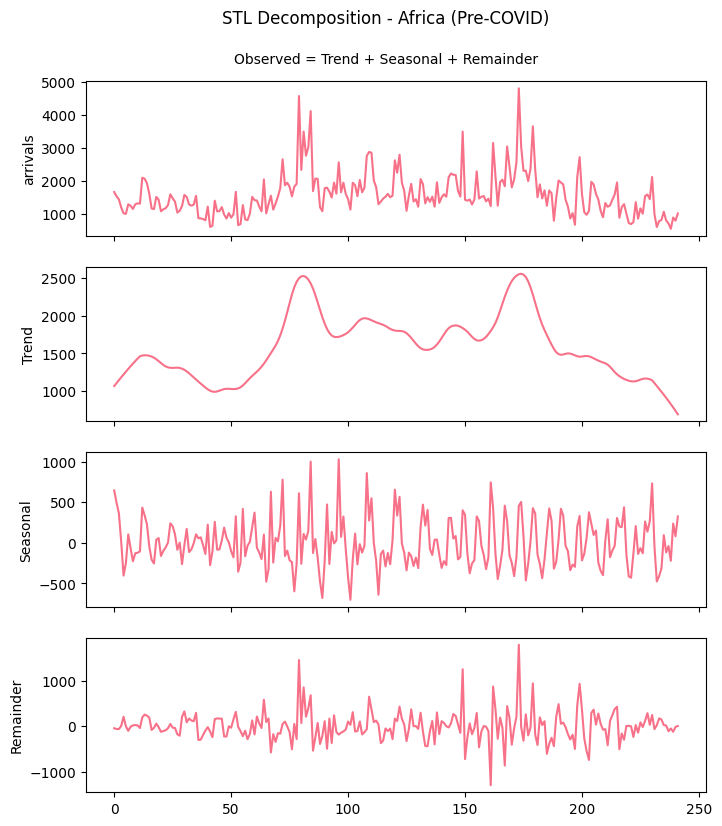


--------------------------------------------------------------------------------


CONTINENT: AMERICA_CENTRAL_E_CARIBE

Observations: 242
Period: 2000-01-01 00:00:00 to 2020-02-01 00:00:00
Mean arrivals: 781.02
Std arrivals: 476.17





--------------------------------------------------------------------------------


CONTINENT: AMERICA_DO_NORTE

Observations: 242
Period: 2000-01-01 00:00:00 to 2020-02-01 00:00:00
Mean arrivals: 16272.19
Std arrivals: 6007.96




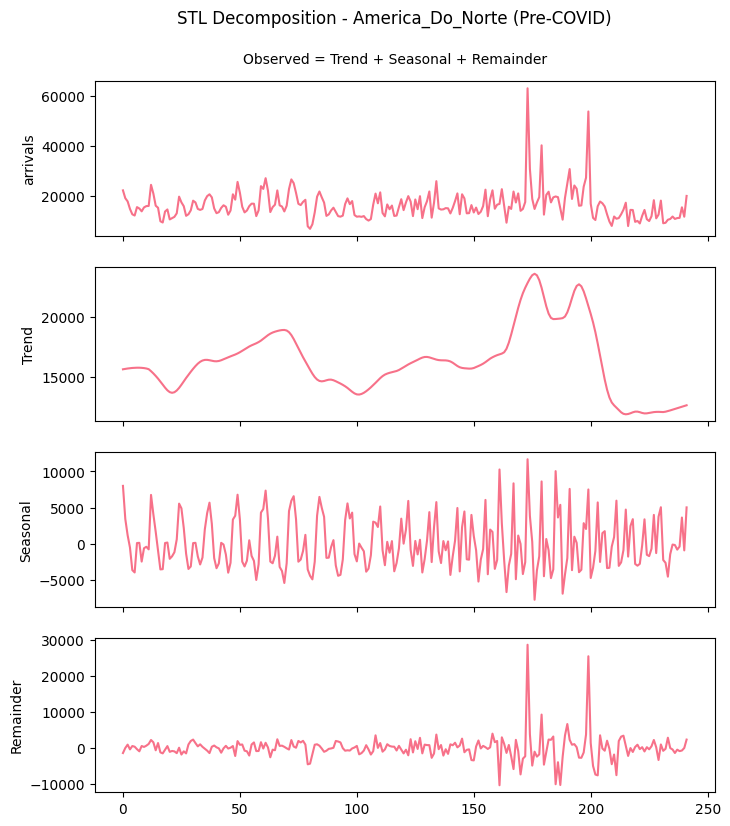


--------------------------------------------------------------------------------


CONTINENT: AMERICA_DO_SUL

Observations: 242
Period: 2000-01-01 00:00:00 to 2020-02-01 00:00:00
Mean arrivals: 29953.98
Std arrivals: 20044.65




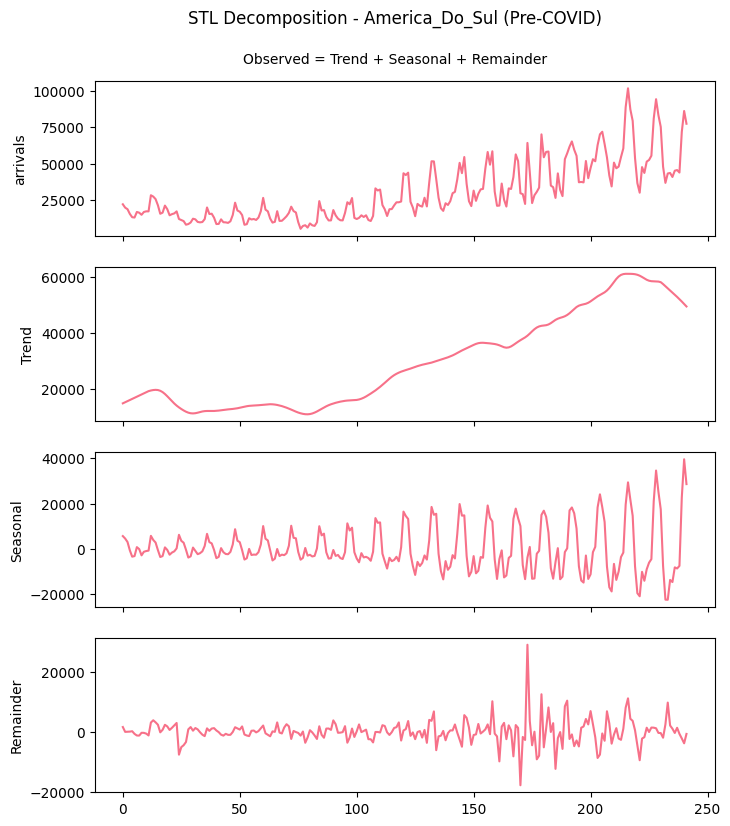


--------------------------------------------------------------------------------


CONTINENT: ASIA

Observations: 242
Period: 2000-01-01 00:00:00 to 2020-02-01 00:00:00
Mean arrivals: 3199.64
Std arrivals: 2061.09




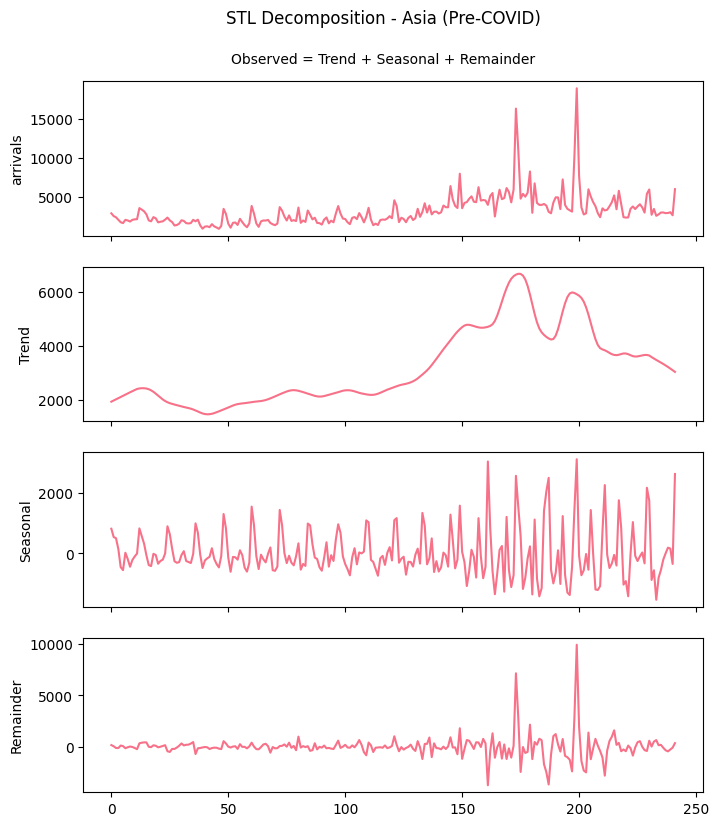


--------------------------------------------------------------------------------


CONTINENT: EUROPA

Observations: 242
Period: 2000-01-01 00:00:00 to 2020-02-01 00:00:00
Mean arrivals: 34284.31
Std arrivals: 10899.43




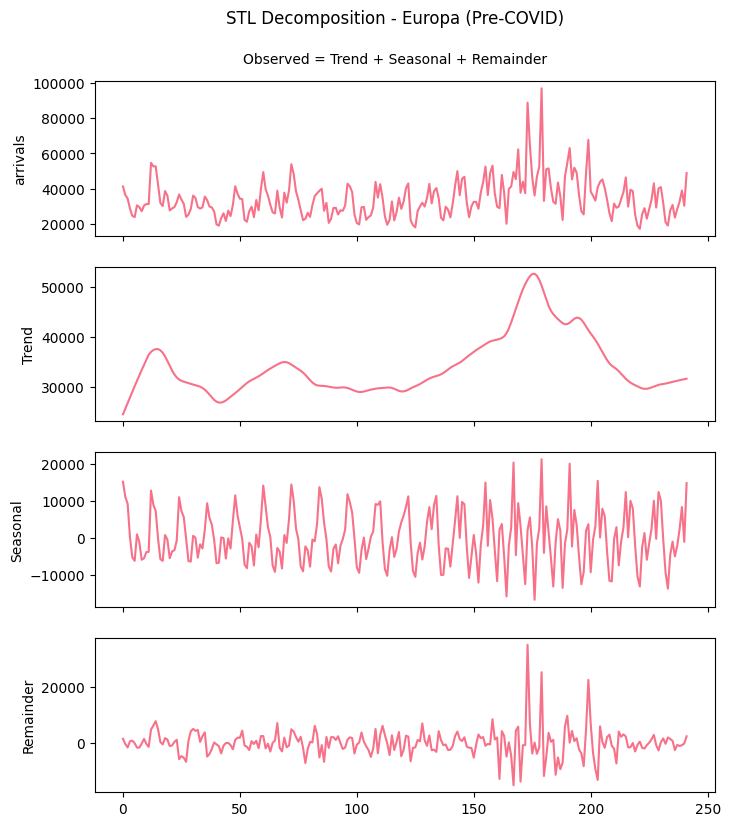


--------------------------------------------------------------------------------


CONTINENT: OCEANIA

Observations: 242
Period: 2000-01-01 00:00:00 to 2020-02-01 00:00:00
Mean arrivals: 1176.10
Std arrivals: 880.25




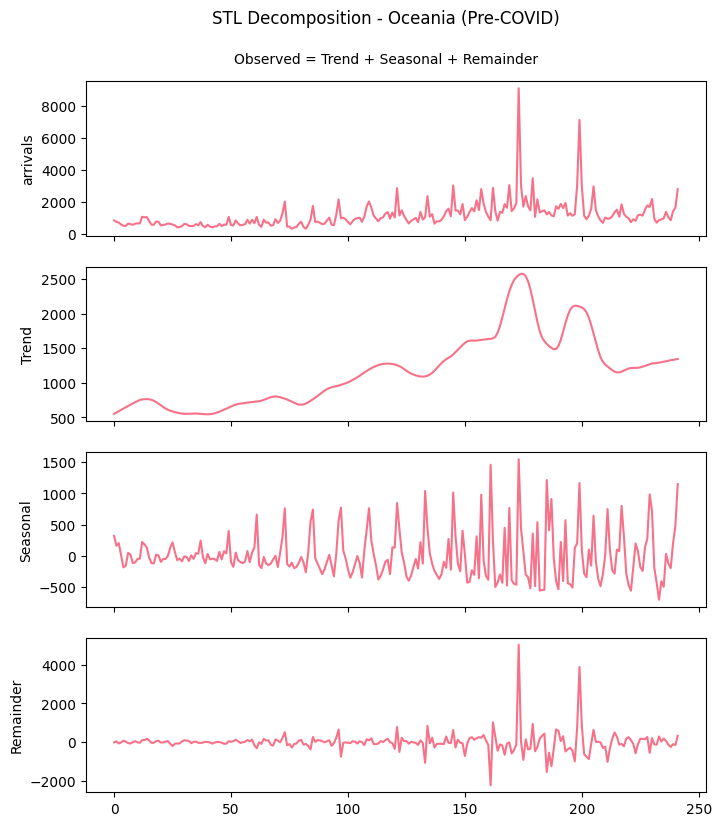


--------------------------------------------------------------------------------


STL Decomposition completed for all continents


In [ ]:
## STL Decomposition - Pre-COVID Period by Continent

# Define pre-COVID period
covid_start = pd.Timestamp('2020-03-01')

# Filter pre-COVID data
df_rj_pre_covid = df_rj[df_rj['date'] < covid_start].copy()

print(f"=== STL Decomposition - Pre-COVID Period ===")
print(f"Period: {df_rj_pre_covid['date'].min()} to {df_rj_pre_covid['date'].max()}")
print(f"Total observations (pre-COVID): {len(df_rj_pre_covid)}")
print("\n" + "="*80 + "\n")

# Get unique continents
continents = sorted(df_rj_pre_covid['continent'].unique())

# Run STL decomposition for each continent
for continent in continents:
    print(f"\n{'='*80}")
    print(f"CONTINENT: {continent.upper()}")
    print(f"{'='*80}\n")
    
    # Filter data for this continent (keep date as column, don't set as index)
    continent_data = df_rj_pre_covid[
        df_rj_pre_covid['continent'] == continent
    ].sort_values('date').copy()
    
    # Print basic info
    print(f"Observations: {len(continent_data)}")
    print(f"Period: {continent_data['date'].min()} to {continent_data['date'].max()}")
    print(f"Mean arrivals: {continent_data['arrivals'].mean():.2f}")
    print(f"Std arrivals: {continent_data['arrivals'].std():.2f}")
    
    # Check for zeros (STL might have issues with zeros)
    zeros_count = (continent_data['arrivals'] == 0).sum()
    if zeros_count > 0:
        print(f"⚠️  Warning: {zeros_count} zero values found")
    
    print("\n")
    
    # Run STL decomposition
    try:
        plot_stl_decomposition(
            df=continent_data,  # Don't set date as index
            value_col='arrivals',
            date_col='date',  # Now we pass date_col
            period=12,  # Monthly seasonality
            title=f'STL Decomposition - {continent.title()} (Pre-COVID)'
        )
    except Exception as e:
        print(f"❌ Error running STL for {continent}: {str(e)}")
        print("Possible reasons: insufficient data, too many zeros, or non-numeric values\n")
        continue
    
    print("\n" + "-"*80 + "\n")

print("\n" + "="*80)
print("STL Decomposition completed for all continents")
print("="*80)

In [11]:
import sys
print(sys.version)

3.13.5 (tags/v3.13.5:6cb20a2, Jun 11 2025, 16:15:46) [MSC v.1943 64 bit (AMD64)]


=== Auto ARIMA with COVID Dummy Variable ===
Dataset period: 2000-01-01 00:00:00 to 2024-12-01 00:00:00


COVID Period: 2020-03-01 to 2023-05-01
Training Period: 2000-01-01 to 2023-12-31
Test Period: 2024-01-01 to 2024-12-01



CONTINENT: AFRICA

Training observations: 288 (2000-01-01 00:00:00 to 2023-12-01 00:00:00)
Test observations: 12 (2024-01-01 00:00:00 to 2024-12-01 00:00:00)
Mean arrivals (train): 1354.68
COVID observations (train): 38

--- Running Grid Search for Best SARIMAX Model ---
This may take a few minutes...
  Tested 50/324 models... Best AICc: 3878.20
  Tested 100/324 models... Best AICc: 3805.84
  Tested 150/324 models... Best AICc: 3804.23
  Tested 200/324 models... Best AICc: 3804.23
  Tested 250/324 models... Best AICc: 3804.23
  Tested 300/324 models... Best AICc: 3804.23

✓ Best Model Found: SARIMA(0, 1, 2) x (1, 1, 2, 12)

✓ Iterações:324
Re-fitting with stationarity and invertibility constraints...
AICc: 3804.23

Model Summary:
                                

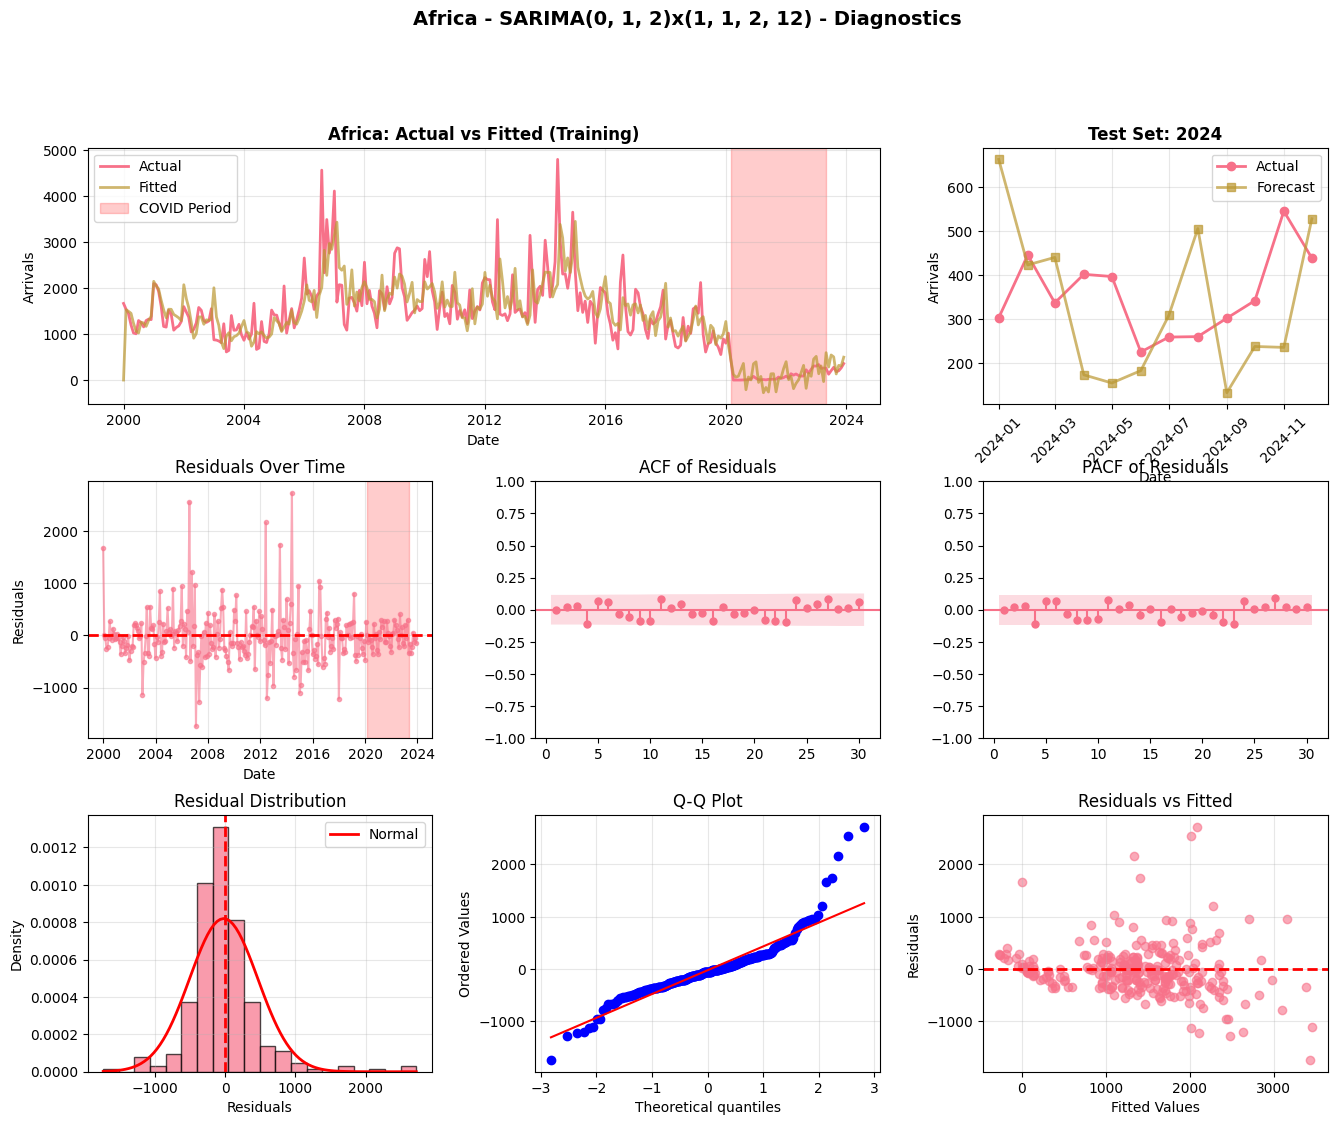


✓ SARIMAX model completed for africa

--------------------------------------------------------------------------------


CONTINENT: AMERICA_CENTRAL_E_CARIBE

Training observations: 288 (2000-01-01 00:00:00 to 2023-12-01 00:00:00)
Test observations: 12 (2024-01-01 00:00:00 to 2024-12-01 00:00:00)
Mean arrivals (train): 745.13
COVID observations (train): 38

--- Running Grid Search for Best SARIMAX Model ---
This may take a few minutes...
  Tested 50/324 models... Best AICc: 3747.35
  Tested 100/324 models... Best AICc: 3710.48
  Tested 150/324 models... Best AICc: 3710.48
  Tested 200/324 models... Best AICc: 3710.48
  Tested 250/324 models... Best AICc: 3710.48
  Tested 300/324 models... Best AICc: 3710.48

✓ Best Model Found: SARIMA(0, 1, 2) x (0, 1, 2, 12)

✓ Iterações:324
Re-fitting with stationarity and invertibility constraints...
AICc: 3710.48

Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                

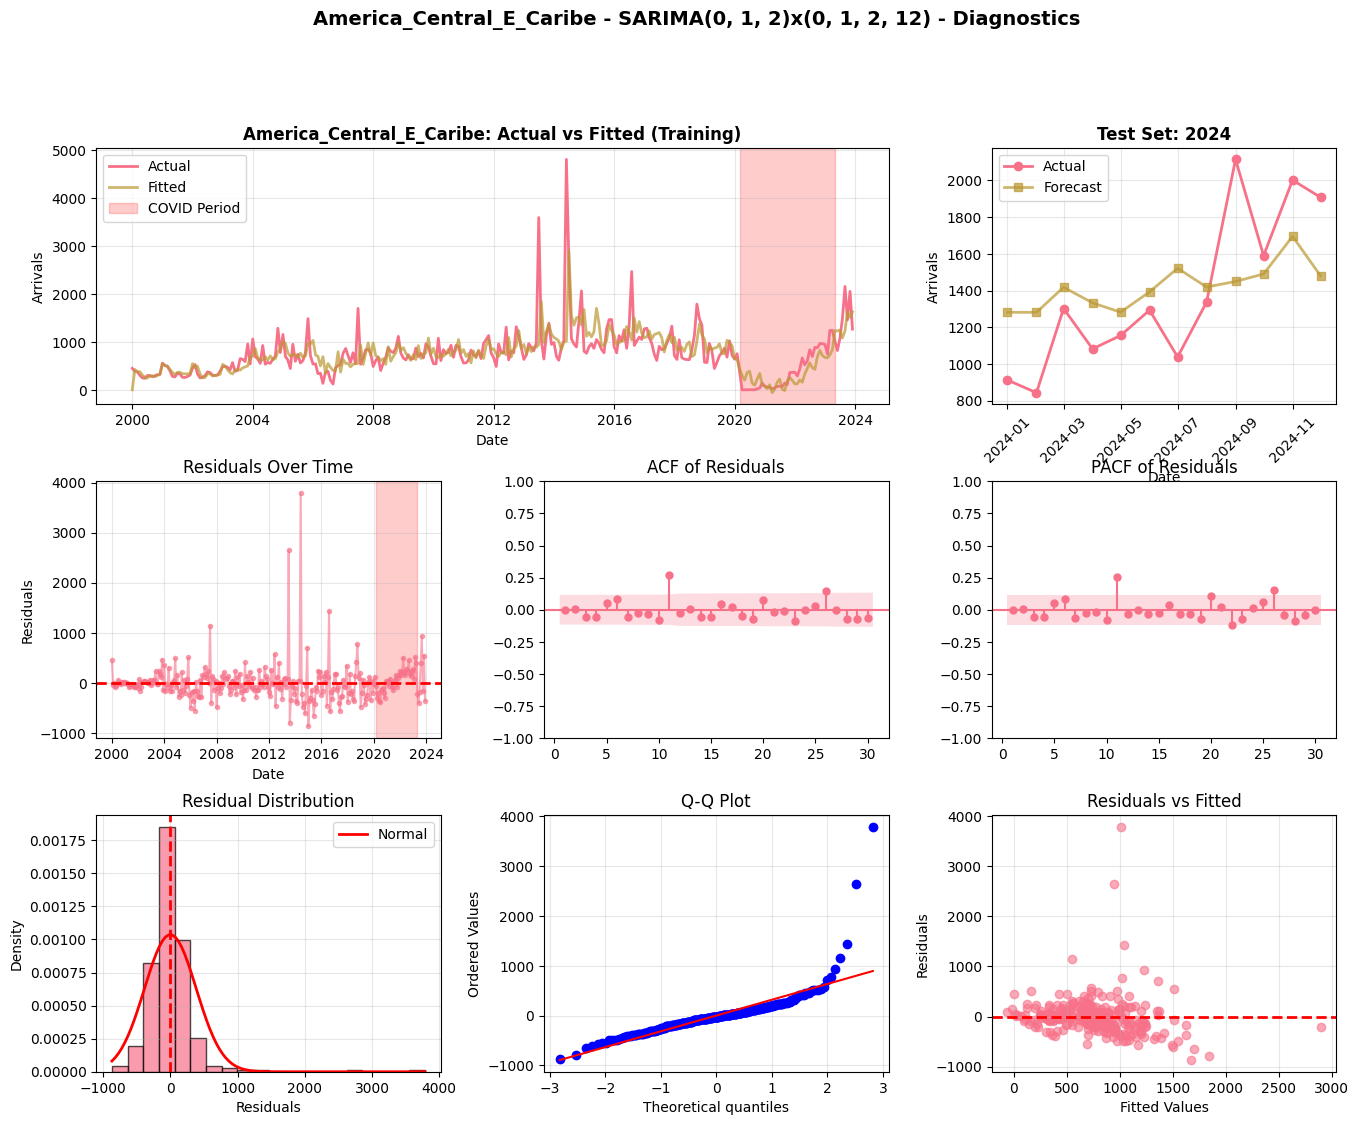


✓ SARIMAX model completed for america_central_e_caribe

--------------------------------------------------------------------------------


CONTINENT: AMERICA_DO_NORTE

Training observations: 288 (2000-01-01 00:00:00 to 2023-12-01 00:00:00)
Test observations: 12 (2024-01-01 00:00:00 to 2024-12-01 00:00:00)
Mean arrivals (train): 14715.67
COVID observations (train): 38

--- Running Grid Search for Best SARIMAX Model ---
This may take a few minutes...
  Tested 50/324 models... Best AICc: 5018.47
  Tested 100/324 models... Best AICc: 4996.66
  Tested 150/324 models... Best AICc: 4996.66
  Tested 200/324 models... Best AICc: 4996.66
  Tested 250/324 models... Best AICc: 4996.66
  Tested 300/324 models... Best AICc: 4996.66

✓ Best Model Found: SARIMA(0, 1, 2) x (0, 1, 2, 12)

✓ Iterações:324
Re-fitting with stationarity and invertibility constraints...
AICc: 4996.66

Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:    


✓ SARIMAX model completed for america_do_norte

--------------------------------------------------------------------------------


CONTINENT: AMERICA_DO_SUL

Training observations: 288 (2000-01-01 00:00:00 to 2023-12-01 00:00:00)
Test observations: 12 (2024-01-01 00:00:00 to 2024-12-01 00:00:00)
Mean arrivals (train): 29106.35
COVID observations (train): 38

--- Running Grid Search for Best SARIMAX Model ---
This may take a few minutes...
  Tested 50/324 models... Best AICc: 5272.68
  Tested 100/324 models... Best AICc: 5188.92
  Tested 150/324 models... Best AICc: 5188.92
  Tested 200/324 models... Best AICc: 5188.92
  Tested 250/324 models... Best AICc: 5184.34
  Tested 300/324 models... Best AICc: 5184.34

✓ Best Model Found: SARIMA(1, 1, 2) x (0, 1, 2, 12)

✓ Iterações:324
Re-fitting with stationarity and invertibility constraints...
AICc: 5184.34

Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:              

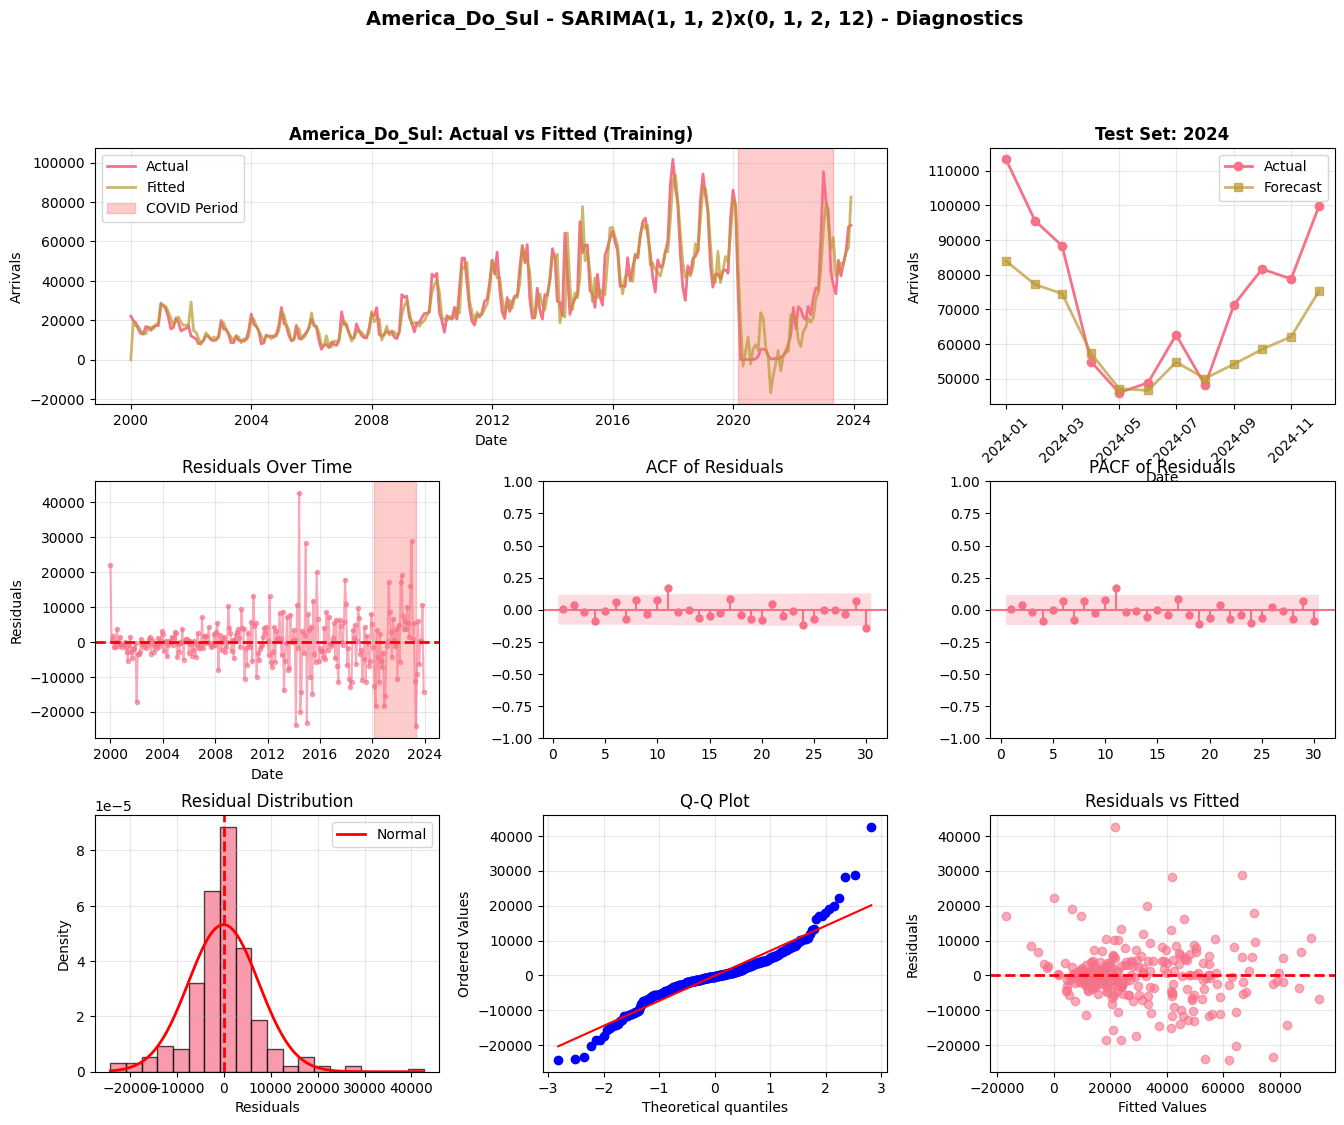


✓ SARIMAX model completed for america_do_sul

--------------------------------------------------------------------------------


CONTINENT: ASIA

Training observations: 288 (2000-01-01 00:00:00 to 2023-12-01 00:00:00)
Test observations: 12 (2024-01-01 00:00:00 to 2024-12-01 00:00:00)
Mean arrivals (train): 2805.19
COVID observations (train): 38

--- Running Grid Search for Best SARIMAX Model ---
This may take a few minutes...
  Tested 50/324 models... Best AICc: 4395.83
  Tested 100/324 models... Best AICc: 4349.77
  Tested 150/324 models... Best AICc: 4349.52
  Tested 200/324 models... Best AICc: 4349.52
  Tested 250/324 models... Best AICc: 4348.25
  Tested 300/324 models... Best AICc: 4348.25

✓ Best Model Found: SARIMA(1, 1, 2) x (1, 1, 2, 12)

✓ Iterações:324
Re-fitting with stationarity and invertibility constraints...
AICc: 4348.25

Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                           


✓ SARIMAX model completed for asia

--------------------------------------------------------------------------------


CONTINENT: EUROPA

Training observations: 288 (2000-01-01 00:00:00 to 2023-12-01 00:00:00)
Test observations: 12 (2024-01-01 00:00:00 to 2024-12-01 00:00:00)
Mean arrivals (train): 30616.88
COVID observations (train): 38

--- Running Grid Search for Best SARIMAX Model ---
This may take a few minutes...
  Tested 50/324 models... Best AICc: 5234.95
  Tested 100/324 models... Best AICc: 5195.47
  Tested 150/324 models... Best AICc: 5195.47
  Tested 200/324 models... Best AICc: 5195.47
  Tested 250/324 models... Best AICc: 5195.47
  Tested 300/324 models... Best AICc: 5195.47

✓ Best Model Found: SARIMA(0, 1, 2) x (0, 1, 2, 12)

✓ Iterações:324
Re-fitting with stationarity and invertibility constraints...
AICc: 5195.47

Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                           arrival

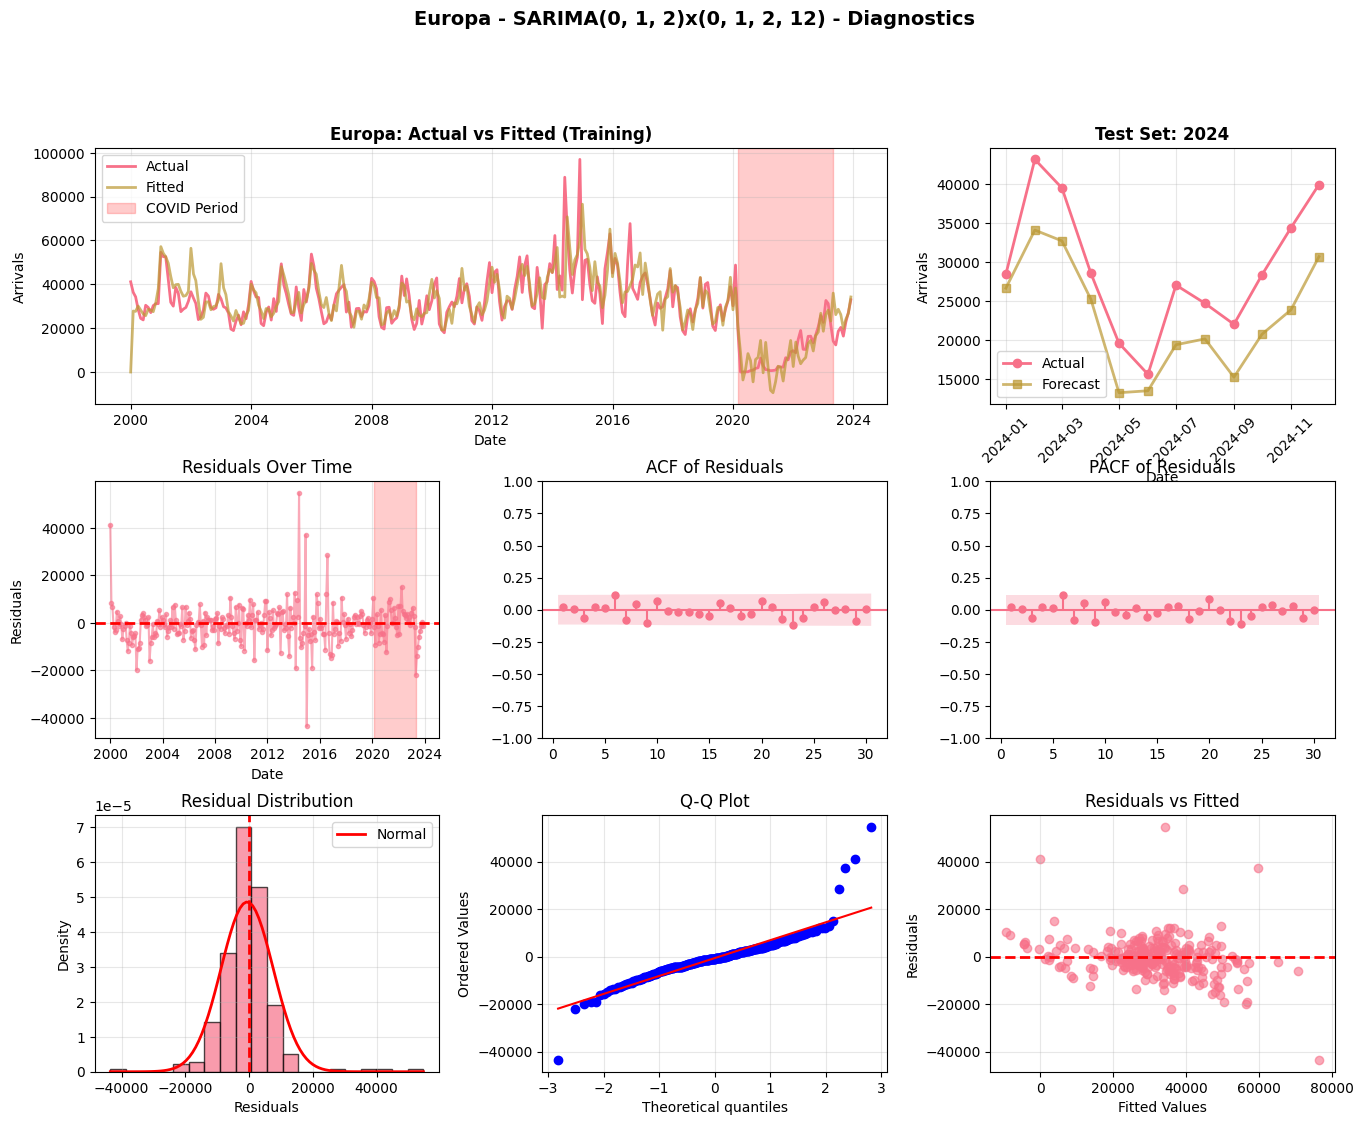


✓ SARIMAX model completed for europa

--------------------------------------------------------------------------------


CONTINENT: OCEANIA

Training observations: 288 (2000-01-01 00:00:00 to 2023-12-01 00:00:00)
Test observations: 12 (2024-01-01 00:00:00 to 2024-12-01 00:00:00)
Mean arrivals (train): 1038.88
COVID observations (train): 38

--- Running Grid Search for Best SARIMAX Model ---
This may take a few minutes...
  Tested 50/324 models... Best AICc: 4042.08
  Tested 100/324 models... Best AICc: 4004.72
  Tested 150/324 models... Best AICc: 4004.19
  Tested 200/324 models... Best AICc: 4004.19
  Tested 250/324 models... Best AICc: 4004.19
  Tested 300/324 models... Best AICc: 4004.19

✓ Best Model Found: SARIMA(0, 1, 2) x (1, 1, 2, 12)

✓ Iterações:324
Re-fitting with stationarity and invertibility constraints...
AICc: 4004.19

Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                           arriv

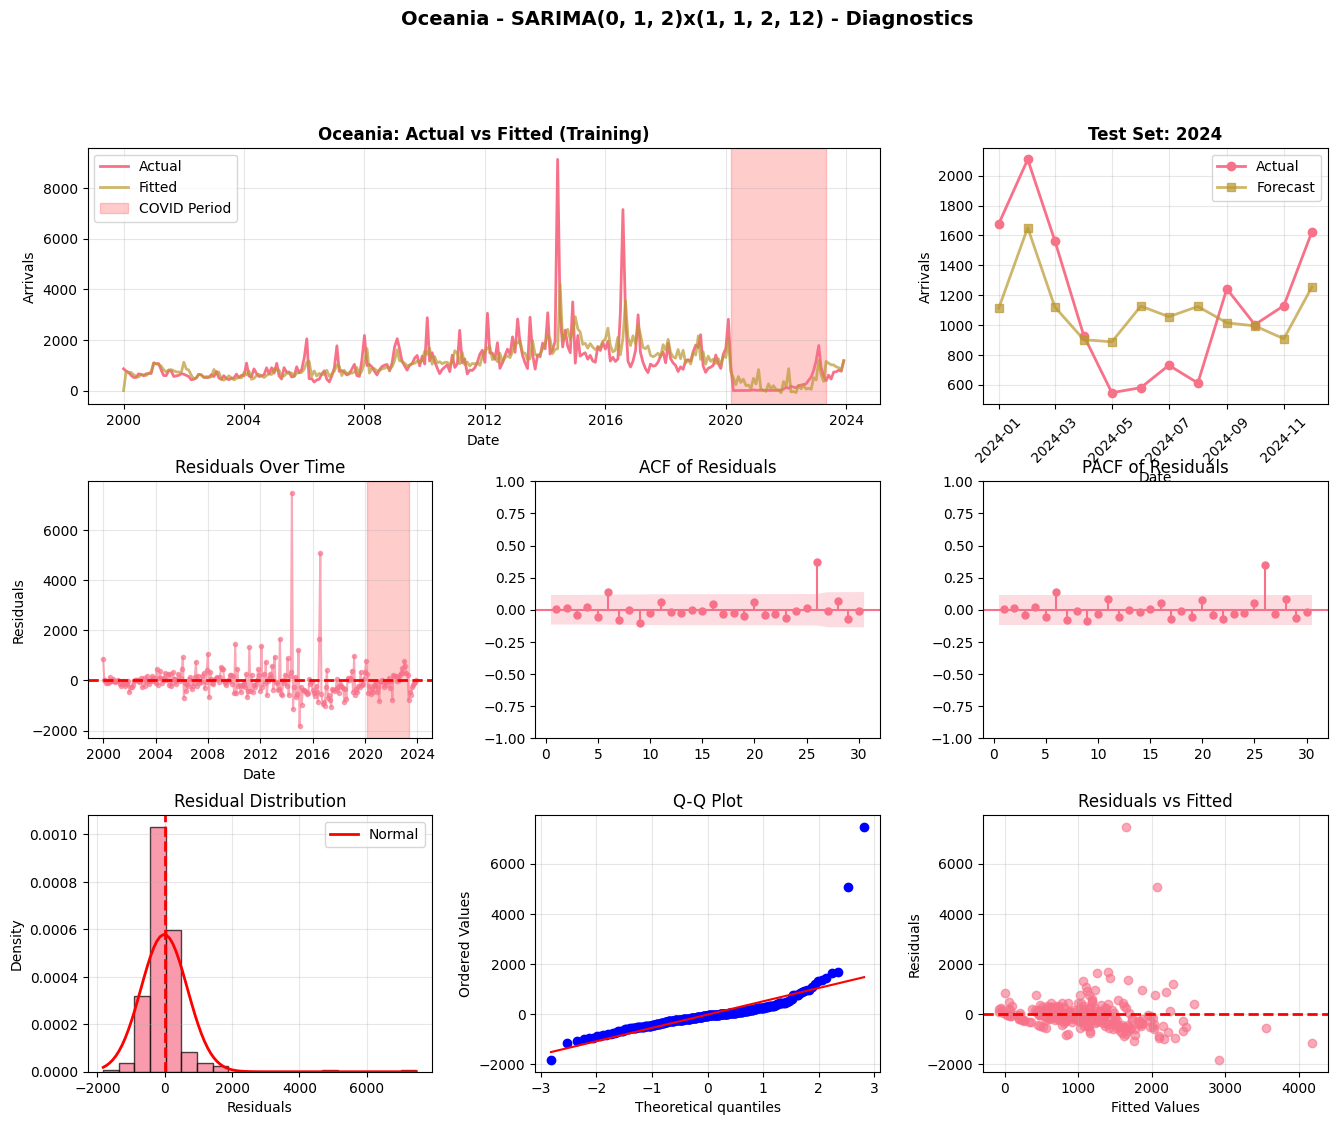


✓ SARIMAX model completed for oceania

--------------------------------------------------------------------------------


SUMMARY OF SARIMAX RESULTS

               Continent                         Model  p  d  q  P  D  Q  s         AIC        AICc         BIC          MAE         RMSE  MAPE (%)    COVID_Coef  COVID_Pvalue COVID_Significant LB_Test JB_Test ARCH_Test Overall_Diagnostic  Train_Obs  Test_Obs
                  Africa SARIMA(0, 1, 2)x(1, 1, 2, 12)  0  1  2  1  1  2 12 4204.711501 4205.130977 4230.028899   164.323947   196.238604 47.492531   -513.338811  0.000000e+00               Yes    Pass    Fail      Pass          Some Fail        288        12
America_Central_E_Caribe SARIMA(0, 1, 2)x(0, 1, 2, 12)  0  1  2  0  1  2 12 4091.927473 4092.240906 4113.628099   288.913247   341.748822 22.625314   -347.670268  1.221067e-01                No    Fail    Fail      Pass          Some Fail        288        12
        America_Do_Norte SARIMA(0, 1, 2)x(0, 1, 2, 12)  0  1  2  0  1

In [ ]:
## Auto ARIMA (SARIMAX) with COVID Dummy Variable - By Continent
## Using statsmodels directly (no pmdarima needed)

from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print(f"=== Auto ARIMA with COVID Dummy Variable ===")
print(f"Dataset period: {df_rj['date'].min()} to {df_rj['date'].max()}")
print("\n" + "="*80 + "\n")

# Define COVID period
covid_start = pd.Timestamp('2020-03-01')
covid_end = pd.Timestamp('2023-05-01')

# Create COVID dummy variable for entire dataset
df_rj['covid_dummy'] = ((df_rj['date'] >= covid_start) & 
                        (df_rj['date'] < covid_end)).astype(int)

# Define train/test split (2024 as test)
train_end = pd.Timestamp('2023-12-31')
test_start = pd.Timestamp('2024-01-01')

print(f"COVID Period: {covid_start.strftime('%Y-%m-%d')} to {covid_end.strftime('%Y-%m-%d')}")
print(f"Training Period: {df_rj['date'].min().strftime('%Y-%m-%d')} to {train_end.strftime('%Y-%m-%d')}")
print(f"Test Period: {test_start.strftime('%Y-%m-%d')} to {df_rj['date'].max().strftime('%Y-%m-%d')}")
print("\n" + "="*80 + "\n")

# Get unique continents
continents = sorted(df_rj['continent'].unique())

# Store results
arima_results = []

# Define parameter ranges for grid search
p_range = range(0, 3)  # [0, 1, 2, 3]
d_range = range(0, 2)  # [0, 1, 2]
q_range = range(0, 3)  # [0, 1, 2, 3]
P_range = range(0, 3)  # [0, 1, 2]  ← REDUZIR PARA 2!
D_range = range(0, 2)  # [0, 1]     ← REDUZIR PARA 2!
Q_range = range(0, 3)  # [0, 1, 2]  ← REDUZIR PARA 2!
s = 12

for continent in continents:
    print(f"\n{'='*80}")
    print(f"CONTINENT: {continent.upper()}")
    print(f"{'='*80}\n")
    
    # Filter data for this continent
    continent_data = df_rj[
        df_rj['continent'] == continent
    ].sort_values('date').copy()
    
    # Set date as index
    continent_data = continent_data.set_index('date')
    
    # Split train/test
    train_data = continent_data[continent_data.index <= train_end]
    test_data = continent_data[continent_data.index >= test_start]
    
    # Prepare data
    y_train = train_data['arrivals']
    exog_train = train_data[['covid_dummy']]
    
    y_test = test_data['arrivals']
    exog_test = test_data[['covid_dummy']]
    
    print(f"Training observations: {len(y_train)} ({y_train.index.min()} to {y_train.index.max()})")
    print(f"Test observations: {len(y_test)} ({y_test.index.min()} to {y_test.index.max()})")
    print(f"Mean arrivals (train): {y_train.mean():.2f}")
    print(f"COVID observations (train): {exog_train['covid_dummy'].sum()}")
    
    print(f"\n--- Running Grid Search for Best SARIMAX Model ---")
    print("This may take a few minutes...")
    
    best_aicc = np.inf
    best_model = None
    best_order = None
    best_seasonal_order = None
    
    # Grid search
    total_models = len(list(product(p_range, d_range, q_range, P_range, D_range, Q_range)))
    model_count = 0
    
    try:
        for p, d, q in product(p_range, d_range, q_range):
            for P, D, Q in product(P_range, D_range, Q_range):
                
                model_count += 1
                try:
                    model = SARIMAX(
                        y_train,
                        exog=exog_train,
                        order=(p, d, q),
                        seasonal_order=(P, D, Q, s),
                        enforce_stationarity=False,
                        enforce_invertibility=False
                    )
                    
                    fitted_model = model.fit(disp=False, maxiter=200)
                    aicc = fitted_model.aicc
                    
                    if aicc < best_aicc:
                        best_aicc = aicc
                        best_model = fitted_model
                        best_order = (p, d, q)
                        best_seasonal_order = (P, D, Q, s)
                        
                    # Progress indicator
                    if model_count % 50 == 0:
                        print(f"  Tested {model_count}/{total_models} models... Best AICc: {best_aicc:.2f}")
                        
                except:
                    continue
        
        # After finding best parameters, re-fit with constraints enabled
        print(f"\n✓ Best Model Found: SARIMA{best_order} x {best_seasonal_order}")
        print(f"\n✓ Iterações:{model_count}")
        print(f"Re-fitting with stationarity and invertibility constraints...")

        best_model = SARIMAX(
            y_train,
            exog=exog_train,
            order=best_order,
            seasonal_order=best_seasonal_order,
            enforce_stationarity=True,   # ✓ NOW WITH CONSTRAINTS
            enforce_invertibility=True   # ✓ NOW WITH CONSTRAINTS
        )

        best_model = best_model.fit(disp=False, maxiter=200)
        
        print(f"AICc: {best_aicc:.2f}")
        print(f"\nModel Summary:")
        print(best_model.summary())
        
        # Extract model parameters
        p, d, q = best_order
        P, D, Q, s_param = best_seasonal_order
        aic = best_model.aic
        aicc = best_model.aicc
        bic = best_model.bic
        
        # Get COVID dummy coefficient
        covid_coef = None
        covid_pvalue = None
        try:
            params = best_model.params
            pvalues = best_model.pvalues
            exog_names = [name for name in params.index if 'x' in name.lower() or 'covid' in name.lower()]
            if len(exog_names) > 0:
                covid_coef = params[exog_names[0]]
                covid_pvalue = pvalues[exog_names[0]]
        except:
            pass
        
        print(f"\n--- COVID Dummy Variable ---")
        if covid_coef is not None:
            print(f"Coefficient: {covid_coef:.4f}")
            print(f"P-value: {covid_pvalue:.4f}")
            if covid_pvalue < 0.05:
                print(f"✓ Statistically significant (p < 0.05)")
                impact = "Negative" if covid_coef < 0 else "Positive"
                print(f"Impact: {impact} ({covid_coef:.2f} arrivals during COVID)")
            else:
                print(f"✗ Not statistically significant (p >= 0.05)")
        else:
            print("⚠️  Could not extract COVID coefficient")
        
        # Make predictions on test set
        print(f"\n--- Test Set Predictions ---")
        forecast = best_model.forecast(steps=len(y_test), exog=exog_test)
        
        # Calculate metrics
        from sklearn.metrics import mean_absolute_error, mean_squared_error
        
        mae = mean_absolute_error(y_test, forecast)
        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        mape = np.mean(np.abs((y_test - forecast) / y_test)) * 100
        
        print(f"MAE (Mean Absolute Error): {mae:.2f}")
        print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
        print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
        
        # Residual diagnostics
        print(f"\n--- Residual Diagnostics (Training Set) ---")
        residuals = best_model.resid
        print(f"Residual Mean: {residuals.mean():.4f}")
        print(f"Residual Std: {residuals.std():.2f}")

            # 0. T-Test for Zero Mean (NEW!)
        print(f"\nT-Test for Zero Mean:")
        from scipy.stats import ttest_1samp
        t_stat, t_pvalue = ttest_1samp(residuals_train, 0)
        print(f"  t-statistic: {t_stat:.4f}")
        print(f"  p-value: {t_pvalue:.4f}")
        
        # Calcular threshold baseado em % do desvio padrão
        threshold_5pct = 0.05 * residuals_train.std()
        threshold_10pct = 0.10 * residuals_train.std()
        mean_abs = abs(residuals_train.mean())
        
        if t_pvalue > 0.05:
            print(f"  ✓ PASS: Mean não é significativamente diferente de zero (p > 0.05)")
            if mean_abs < threshold_5pct:
                print(f"  ✓✓ EXCELENTE: |Mean| < 5% do Std ({threshold_5pct:.2f})")
                mean_result = "Excellent"
            elif mean_abs < threshold_10pct:
                print(f"  ✓ BOM: |Mean| < 10% do Std ({threshold_10pct:.2f})")
                mean_result = "Good"
            else:
                print(f"  ⚠️ ACEITÁVEL: |Mean| > 10% do Std, mas estatisticamente = 0")
                mean_result = "Acceptable"
        else:
            print(f"  ✗ FAIL: Mean é significativamente diferente de zero (p < 0.05)")
            if residuals_train.mean() > 0:
                print(f"  → Modelo SUBESTIMA sistematicamente os valores reais")
            else:
                print(f"  → Modelo SUPERESTIMA sistematicamente os valores reais")
            mean_result = "Biased"
        
        # 1. Ljung-Box Test (autocorrelation)
        lb_test = acorr_ljungbox(residuals, lags=24, return_df=True)
        lb_pvalue = lb_test['lb_pvalue'].iloc[-1]  # Last lag p-value
        print(f"\nLjung-Box Test (lag 24):")
        print(f"  p-value: {lb_pvalue:.4f}")
        if lb_pvalue > 0.05:
            print(f"  ✓ PASS: No significant autocorrelation (p > 0.05)")
            lb_result = "Pass"
        else:
            print(f"  ✗ FAIL: Significant autocorrelation detected (p < 0.05)")
            lb_result = "Fail"
        
        # 2. Jarque-Bera Test (normality)
        jb_stat, jb_pvalue = stats.jarque_bera(residuals)
        print(f"\nJarque-Bera Test (Normality):")
        print(f"  Statistic: {jb_stat:.4f}")
        print(f"  p-value: {jb_pvalue:.4f}")
        if jb_pvalue > 0.05:
            print(f"  ✓ PASS: Residuals are normally distributed (p > 0.05)")
            jb_result = "Pass"
        else:
            print(f"  ✗ FAIL: Residuals are not normally distributed (p < 0.05)")
            jb_result = "Fail"
        
        # 3. Heteroskedasticity (visual inspection + test)
        from statsmodels.stats.diagnostic import het_arch
        try:
            arch_test = het_arch(residuals, nlags=10)
            arch_pvalue = arch_test[1]
            print(f"\nARCH Test (Heteroskedasticity):")
            print(f"  p-value: {arch_pvalue:.4f}")
            if arch_pvalue > 0.05:
                print(f"  ✓ PASS: No heteroskedasticity (p > 0.05)")
                arch_result = "Pass"
            else:
                print(f"  ✗ FAIL: Heteroskedasticity detected (p < 0.05)")
                arch_result = "Fail"
        except:
            arch_result = "Error"
            print(f"\nARCH Test: Could not be performed")
        
        # Overall diagnostic result
        print(f"\n--- Overall Residual Diagnostics ---")
        all_pass = all([lb_result == "Pass", jb_result == "Pass", arch_result == "Pass"])
        if all_pass:
            print("✓✓✓ ALL TESTS PASSED - Model residuals are well-behaved")
            diagnostic_result = "All Pass"
        else:
            print("⚠️ SOME TESTS FAILED - Review residual diagnostics")
            diagnostic_result = "Some Fail"
        
        # Plot diagnostics
        fig = plt.figure(figsize=(16, 12))
        gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
        
        # Plot 1: Fitted vs Actual (Training)
        ax1 = fig.add_subplot(gs[0, :2])
        fitted = best_model.fittedvalues
        ax1.plot(y_train.index, y_train.values, label='Actual', linewidth=2)
        ax1.plot(y_train.index, fitted, label='Fitted', linewidth=2, alpha=0.7)
        ax1.axvspan(covid_start, covid_end, alpha=0.2, color='red', label='COVID Period')
        ax1.set_title(f'{continent.title()}: Actual vs Fitted (Training)', fontsize=12, fontweight='bold')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Arrivals')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Forecast vs Actual (Test)
        ax2 = fig.add_subplot(gs[0, 2])
        ax2.plot(y_test.index, y_test.values, label='Actual', linewidth=2, marker='o')
        ax2.plot(y_test.index, forecast, label='Forecast', linewidth=2, alpha=0.7, marker='s')
        ax2.set_title(f'Test Set: 2024', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Arrivals')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.tick_params(axis='x', rotation=45)
        
        # Plot 3: Residuals over time
        ax3 = fig.add_subplot(gs[1, 0])
        ax3.plot(residuals.index, residuals, marker='o', markersize=3, alpha=0.6)
        ax3.axhline(y=0, color='r', linestyle='--', linewidth=2)
        ax3.axvspan(covid_start, covid_end, alpha=0.2, color='red')
        ax3.set_title('Residuals Over Time')
        ax3.set_xlabel('Date')
        ax3.set_ylabel('Residuals')
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: ACF of Residuals
        ax4 = fig.add_subplot(gs[1, 1])
        plot_acf(residuals, lags=30, ax=ax4, zero=False)
        ax4.set_title('ACF of Residuals')
        
        # Plot 5: PACF of Residuals
        ax5 = fig.add_subplot(gs[1, 2])
        plot_pacf(residuals, lags=30, ax=ax5, zero=False)
        ax5.set_title('PACF of Residuals')
        
        # Plot 6: Histogram of Residuals
        ax6 = fig.add_subplot(gs[2, 0])
        ax6.hist(residuals, bins=20, alpha=0.7, edgecolor='black', density=True)
        ax6.axvline(x=0, color='r', linestyle='--', linewidth=2)
        # Add normal distribution overlay
        mu, sigma = residuals.mean(), residuals.std()
        x = np.linspace(residuals.min(), residuals.max(), 100)
        ax6.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal')
        ax6.set_title('Residual Distribution')
        ax6.set_xlabel('Residuals')
        ax6.set_ylabel('Density')
        ax6.legend()
        ax6.grid(True, alpha=0.3)
        
        # Plot 7: Q-Q Plot
        ax7 = fig.add_subplot(gs[2, 1])
        stats.probplot(residuals, dist="norm", plot=ax7)
        ax7.set_title('Q-Q Plot')
        ax7.grid(True, alpha=0.3)
        
        # Plot 8: Residuals vs Fitted
        ax8 = fig.add_subplot(gs[2, 2])
        ax8.scatter(fitted, residuals, alpha=0.6)
        ax8.axhline(y=0, color='r', linestyle='--', linewidth=2)
        ax8.set_xlabel('Fitted Values')
        ax8.set_ylabel('Residuals')
        ax8.set_title('Residuals vs Fitted')
        ax8.grid(True, alpha=0.3)
        
        plt.suptitle(f'{continent.title()} - SARIMA{best_order}x{best_seasonal_order} - Diagnostics', 
                     fontsize=14, fontweight='bold', y=0.995)
        plt.show()
        
        # Store results
        arima_results.append({
            'Continent': continent.title(),
            'Model': f'SARIMA{best_order}x{best_seasonal_order}',
            'p': p, 'd': d, 'q': q,
            'P': P, 'D': D, 'Q': Q, 's': s_param,
            'AIC': aic,
            'AICc': aicc,
            'BIC': bic,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'COVID_Coef': covid_coef if covid_coef is not None else np.nan,
            'COVID_Pvalue': covid_pvalue if covid_pvalue is not None else np.nan,
            'COVID_Significant': 'Yes' if (covid_pvalue is not None and covid_pvalue < 0.05) else 'No',
            'LB_Test': lb_result,
            'JB_Test': jb_result,
            'ARCH_Test': arch_result,
            'Overall_Diagnostic': diagnostic_result,
            'Train_Obs': len(y_train),
            'Test_Obs': len(y_test)
        })
        
        print(f"\n✓ SARIMAX model completed for {continent}")
        
    except Exception as e:
        print(f"\n❌ Error running SARIMAX for {continent}: {str(e)}")
        import traceback
        traceback.print_exc()
        arima_results.append({
            'Continent': continent.title(),
            'Model': 'Error',
            'p': np.nan, 'd': np.nan, 'q': np.nan,
            'P': np.nan, 'D': np.nan, 'Q': np.nan, 's': np.nan,
            'AIC': np.nan,
            'AICc': np.nan,
            'BIC': np.nan,
            'MAE': np.nan,
            'RMSE': np.nan,
            'MAPE (%)': np.nan,
            'COVID_Coef': np.nan,
            'COVID_Pvalue': np.nan,
            'COVID_Significant': 'Error',
            'LB_Test': 'Error',
            'JB_Test': 'Error',
            'ARCH_Test': 'Error',
            'Overall_Diagnostic': 'Error',
            'Train_Obs': np.nan,
            'Test_Obs': np.nan
        })
        continue
    
    print("\n" + "-"*80 + "\n")

# Summary table
print("\n" + "="*80)
print("SUMMARY OF SARIMAX RESULTS")
print("="*80 + "\n")

results_df = pd.DataFrame(arima_results)
print(results_df.to_string(index=False))

print("\n" + "="*80)
print("PERFORMANCE METRICS RANKING")
print("="*80 + "\n")

# Rank by RMSE
print("Best models by RMSE (lower is better):")
print(results_df.sort_values('RMSE')[['Continent', 'Model', 'RMSE', 'MAE', 'MAPE (%)']].to_string(index=False))

print("\n" + "="*80)
print("Notes:")
print("- SARIMA(p,d,q)x(P,D,Q,s) where s=12 (monthly seasonality)")
print("- AICc: Corrected AIC (better for small samples)")
print("- MAE: Mean Absolute Error")
print("- RMSE: Root Mean Squared Error")
print("- MAPE: Mean Absolute Percentage Error")
print("- LB_Test: Ljung-Box (autocorrelation) - Pass means no autocorrelation")
print("- JB_Test: Jarque-Bera (normality) - Pass means residuals are normal")
print("- ARCH_Test: Heteroskedasticity - Pass means constant variance")
print("- Lower RMSE/MAE/MAPE = Better predictions")
print("- Lower AICc/BIC = Better model fit")
print("="*80)

In [17]:
## Re-train Models with Log Transformation for ARCH Test Failures
## Uses log1p transformation to handle zero values: log1p(x) = log(1 + x)

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("\n" + "="*80)
print("RE-TRAINING MODELS WITH LOG TRANSFORMATION (ARCH FAILURES)")
print("="*80 + "\n")

# Identify continents that failed ARCH test
arch_failures = results_df[results_df['ARCH_Test'] == 'Fail']['Continent'].tolist()

if len(arch_failures) == 0:
    print("✓ No models failed ARCH test - skipping log transformation")
else:
    print(f"Continents with heteroskedasticity issues: {', '.join(arch_failures)}")
    print(f"Applying log1p transformation: log(1 + x) - handles zeros safely\n")
    
    # Store improved results
    improved_results = []
    
    for continent_name in arch_failures:
        print(f"\n{'='*80}")
        print(f"RE-TRAINING: {continent_name.upper()} with LOG TRANSFORMATION")
        print(f"{'='*80}\n")
        
        # Get original model parameters
        original = results_df[results_df['Continent'] == continent_name].iloc[0]
        p, d, q = int(original['p']), int(original['d']), int(original['q'])
        P, D, Q = int(original['P']), int(original['D']), int(original['Q'])
        
        print(f"Original model: SARIMA({p},{d},{q})x({P},{D},{Q},{s})")
        print(f"Original ARCH test: FAIL")
        print(f"Original RMSE: {original['RMSE']:.2f}\n")
        
        # Filter data
        continent = continent_name.lower().replace(' ', '_')
        continent_data = df_rj[
            df_rj['continent'] == continent
        ].sort_values('date').copy()
        
        continent_data = continent_data.set_index('date')
        
        # Split train/test
        train_data = continent_data[continent_data.index <= train_end]
        test_data = continent_data[continent_data.index >= test_start]
        
        # Check for zeros BEFORE transformation
        zeros_train = (train_data['arrivals'] == 0).sum()
        zeros_test = (test_data['arrivals'] == 0).sum()
        
        print(f"Data check:")
        print(f"  Training zeros: {zeros_train} / {len(train_data)} ({zeros_train/len(train_data)*100:.1f}%)")
        print(f"  Test zeros: {zeros_test} / {len(test_data)} ({zeros_test/len(test_data)*100:.1f}%)")
        print(f"  Min value (train): {train_data['arrivals'].min():.0f}")
        print(f"  Max value (train): {train_data['arrivals'].max():.0f}")
        
        # ✓ APPLY LOG1P TRANSFORMATION (handles zeros: log1p(x) = log(1+x))
        # This means: log(0) is undefined, but log1p(0) = log(1) = 0 ✓
        y_train_original = train_data['arrivals']
        y_train_log = np.log1p(train_data['arrivals'])  # log(1 + x)
        exog_train = train_data[['covid_dummy']]
        
        y_test_original = test_data['arrivals']
        y_test_log = np.log1p(test_data['arrivals'])  # log(1 + x)
        exog_test = test_data[['covid_dummy']]
        
        print(f"\nLog1p transformation applied:")
        print(f"  Original range: [{y_train_original.min():.0f}, {y_train_original.max():.0f}]")
        print(f"  Log range: [{y_train_log.min():.4f}, {y_train_log.max():.4f}]")
        print(f"  Transformation: y_log = log(1 + y_original)")
        print(f"  Back-transform: y_original = exp(y_log) - 1")
        
        # Verify transformation handled zeros
        if zeros_train > 0:
            print(f"  ✓ Zero values handled: log1p(0) = {np.log1p(0):.4f}")
        print()
        
        try:
            # Fit model on LOG-TRANSFORMED data
            model_log = SARIMAX(
                y_train_log,
                exog=exog_train,
                order=(p, d, q),
                seasonal_order=(P, D, Q, s),
                enforce_stationarity=True,
                enforce_invertibility=True
            )
            
            fitted_model_log = model_log.fit(disp=False, maxiter=200)
            
            # Forecast in LOG space
            forecast_log = fitted_model_log.forecast(steps=len(y_test_log), exog=exog_test)
            
            # ✓ BACK-TRANSFORM to original scale: expm1(x) = exp(x) - 1
            # This is the inverse of log1p
            forecast_original = np.expm1(forecast_log)
            
            # Ensure no negative forecasts (can happen with very small log values)
            forecast_original = np.maximum(forecast_original, 0)
            
            # Calculate metrics in ORIGINAL scale
            mae_log = mean_absolute_error(y_test_original, forecast_original)
            rmse_log = np.sqrt(mean_squared_error(y_test_original, forecast_original))
            
            # Handle MAPE safely (avoid division by zero)
            mask = y_test_original > 0
            if mask.sum() > 0:
                mape_log = np.mean(np.abs((y_test_original[mask] - forecast_original[mask]) / y_test_original[mask])) * 100
            else:
                mape_log = np.nan
            
            # Residual diagnostics on LOG-TRANSFORMED residuals
            residuals_log = fitted_model_log.resid
            
            print(f"--- Log Model Fitted ---")
            print(f"Converged: {fitted_model_log.mle_retvals['converged']}")
            print(f"AICc: {fitted_model_log.aicc:.2f}")
            
            # ARCH test on log residuals
            from statsmodels.stats.diagnostic import het_arch
            try:
                arch_test_log = het_arch(residuals_log, nlags=10)
                arch_pvalue_log = arch_test_log[1]
                
                if arch_pvalue_log > 0.05:
                    arch_result_log = "Pass"
                    print(f"\n✓ ARCH Test (log): PASS (p={arch_pvalue_log:.4f})")
                else:
                    arch_result_log = "Fail"
                    print(f"\n✗ ARCH Test (log): FAIL (p={arch_pvalue_log:.4f})")
            except Exception as e:
                arch_result_log = "Error"
                arch_pvalue_log = np.nan
                print(f"\n⚠️  ARCH Test: Error - {str(e)}")
            
            # Ljung-Box on log residuals
            lb_test_log = acorr_ljungbox(residuals_log, lags=20, return_df=True)
            lb_pvalue_log = lb_test_log['lb_pvalue'].iloc[-1]
            lb_result_log = "Pass" if lb_pvalue_log > 0.05 else "Fail"
            
            # Jarque-Bera on log residuals
            jb_stat_log, jb_pvalue_log = stats.jarque_bera(residuals_log)
            jb_result_log = "Pass" if jb_pvalue_log > 0.05 else "Fail"
            
            print(f"\n--- Log Model Performance (Original Scale) ---")
            print(f"MAE:  {mae_log:.2f} (original: {original['MAE']:.2f}) | Change: {mae_log - original['MAE']:.2f}")
            print(f"RMSE: {rmse_log:.2f} (original: {original['RMSE']:.2f}) | Change: {rmse_log - original['RMSE']:.2f}")
            if not np.isnan(mape_log):
                print(f"MAPE: {mape_log:.2f}% (original: {original['MAPE (%)']:.2f}%) | Change: {mape_log - original['MAPE (%)']:.2f}%")
            
            print(f"\n--- Log Model Diagnostics ---")
            print(f"Ljung-Box: {lb_result_log} (p={lb_pvalue_log:.4f})")
            print(f"Jarque-Bera: {jb_result_log} (p={jb_pvalue_log:.4f})")
            print(f"ARCH: {arch_result_log} (p={arch_pvalue_log:.4f})")
            
            # ✓✓✓ CRITÉRIO: SÓ USA LOG SE RMSE MELHORAR
            rmse_improved = rmse_log < original['RMSE']
            mae_improved = mae_log < original['MAE']
            arch_fixed = arch_result_log == "Pass" and original['ARCH_Test'] == "Fail"
            
            print(f"\n--- Improvement Summary ---")
            print(f"ARCH fixed: {'✓ YES' if arch_fixed else '✗ NO'}")
            
            rmse_pct = ((original['RMSE'] - rmse_log) / original['RMSE'] * 100) if original['RMSE'] > 0 else 0
            mae_pct = ((original['MAE'] - mae_log) / original['MAE'] * 100) if original['MAE'] > 0 else 0
            
            print(f"RMSE improved: {'✓ YES' if rmse_improved else '✗ NO'} ({rmse_pct:+.1f}%)")
            print(f"MAE improved: {'✓ YES' if mae_improved else '✗ NO'} ({mae_pct:+.1f}%)")
            
            # ✓ DECISÃO: Usa log model SE E SOMENTE SE RMSE melhorar
            if rmse_improved:
                print(f"\n✓✓✓ LOG MODEL IS BETTER (RMSE improved by {abs(rmse_pct):.1f}%) - Will use for final predictions")
                use_log_model = True
            else:
                print(f"\n⚠️ LOG MODEL NOT BETTER (RMSE worse by {abs(rmse_pct):.1f}%) - Will keep original model")
                use_log_model = False
            
            # Store improved result
            improved_results.append({
                'Continent': continent_name,
                'Original_RMSE': original['RMSE'],
                'Log_RMSE': rmse_log,
                'Original_ARCH': original['ARCH_Test'],
                'Log_ARCH': arch_result_log,
                'Use_Log': use_log_model,
                'RMSE_Improvement_%': rmse_pct
            })
            
            # Update results_df ONLY if log model has better RMSE
            if use_log_model:
                idx = results_df[results_df['Continent'] == continent_name].index[0]
                results_df.at[idx, 'MAE'] = mae_log
                results_df.at[idx, 'RMSE'] = rmse_log
                if not np.isnan(mape_log):
                    results_df.at[idx, 'MAPE (%)'] = mape_log
                results_df.at[idx, 'ARCH_Test'] = arch_result_log
                results_df.at[idx, 'LB_Test'] = lb_result_log
                results_df.at[idx, 'JB_Test'] = jb_result_log
                results_df.at[idx, 'Model'] = f"SARIMA{(p,d,q)}x{(P,D,Q,s)}-LOG"
                
                # Update diagnostic
                all_pass = all([lb_result_log == "Pass", jb_result_log == "Pass", arch_result_log == "Pass"])
                results_df.at[idx, 'Overall_Diagnostic'] = "All Pass" if all_pass else "Some Fail"
            
        except Exception as e:
            print(f"\n❌ Error with log transformation: {str(e)}")
            import traceback
            traceback.print_exc()
            continue
    
    # Summary of improvements
    if len(improved_results) > 0:
        print(f"\n{'='*80}")
        print("LOG TRANSFORMATION SUMMARY")
        print(f"{'='*80}\n")
        
        improved_df = pd.DataFrame(improved_results)
        print(improved_df.to_string(index=False))
        
        print(f"\n✓ Models using log transformation: {improved_df['Use_Log'].sum()}")
        print(f"✓ ARCH tests fixed: {(improved_df['Log_ARCH'] == 'Pass').sum()}")
        print(f"✓ RMSE improved: {(improved_df['RMSE_Improvement_%'] > 0).sum()}")

print("\n" + "="*80)
print("✓ Log transformation analysis completed")
print("="*80)


RE-TRAINING MODELS WITH LOG TRANSFORMATION (ARCH FAILURES)

Continents with heteroskedasticity issues: America_Do_Sul, Europa
Applying log1p transformation: log(1 + x) - handles zeros safely


RE-TRAINING: AMERICA_DO_SUL with LOG TRANSFORMATION

Original model: SARIMA(1,1,2)x(0,1,2,12)
Original ARCH test: FAIL
Original RMSE: 16277.47

Data check:
  Training zeros: 2 / 288 (0.7%)
  Test zeros: 0 / 12 (0.0%)
  Min value (train): 0
  Max value (train): 101656

Log1p transformation applied:
  Original range: [0, 101656]
  Log range: [0.0000, 11.5294]
  Transformation: y_log = log(1 + y_original)
  Back-transform: y_original = exp(y_log) - 1
  ✓ Zero values handled: log1p(0) = 0.0000

--- Log Model Fitted ---
Converged: True
AICc: 606.97

✓ ARCH Test (log): PASS (p=1.0000)

--- Log Model Performance (Original Scale) ---
MAE:  29413.09 (original: 13228.02) | Change: 16185.07
RMSE: 30763.91 (original: 16277.47) | Change: 14486.44
MAPE: 43.85% (original: 15.60%) | Change: 28.26%

--- Log Mode


MANUAL SARIMAX MODEL TRAINING

Target Continent: America Central E Caribe
SARIMA Order: (3, 1, 2)
Seasonal Order: (3, 1, 2, 12)
Log Transformation: False

--------------------------------------------------------------------------------

Training period: 2000-01-01 00:00:00 to 2023-12-01 00:00:00
Test period: 2024-01-01 00:00:00 to 2024-12-01 00:00:00
Training observations: 288
Test observations: 12

Zeros in training: 5 (1.7%)
Zeros in test: 0 (0.0%)

--------------------------------------------------------------------------------

Fitting SARIMAX model...
✓ Model fitted successfully
Converged: True

AIC: 4103.32
AICc: 4104.51
BIC: 4146.73

--------------------------------------------------------------------------------

Generating forecasts...

--- Forecast Performance Metrics ---
MAE (Mean Absolute Error): 293.21
RMSE (Root Mean Squared Error): 340.47
MAPE (Mean Absolute Percentage Error): 23.39%

--------------------------------------------------------------------------------

Runn

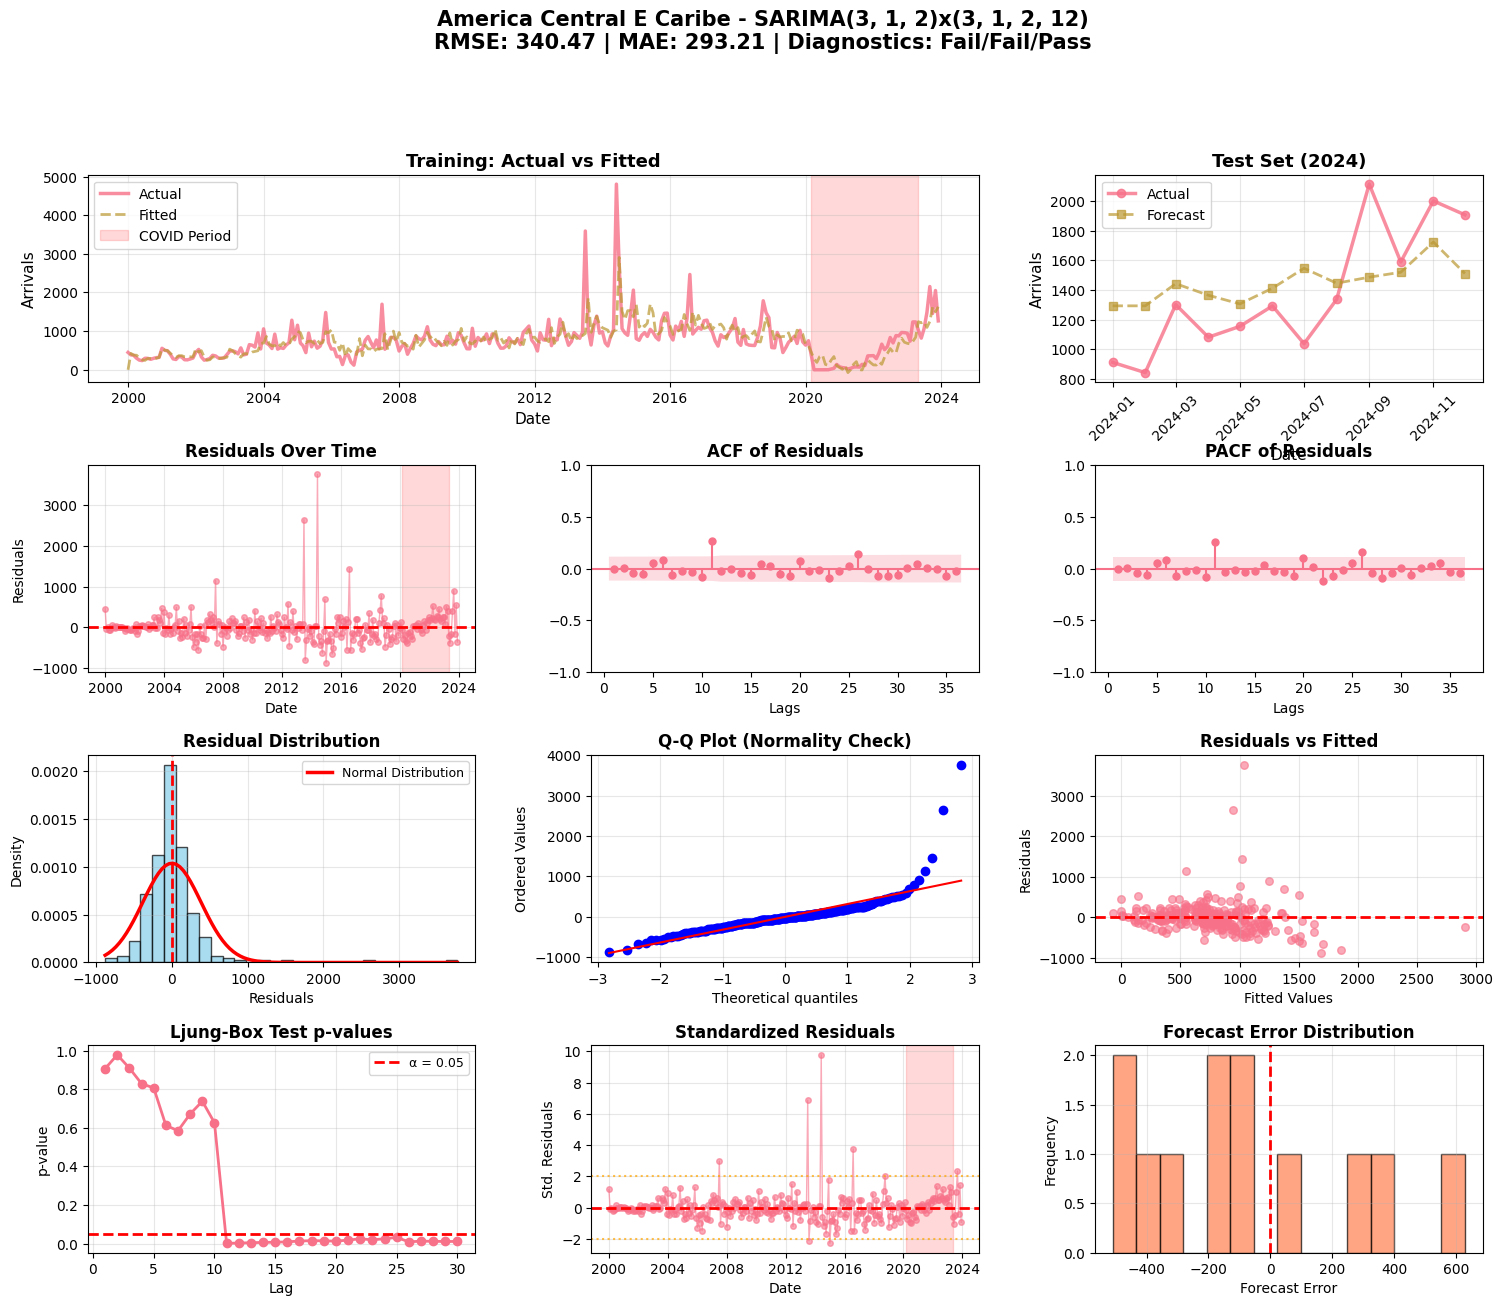


✓ All diagnostic plots created successfully

MANUAL MODEL SUMMARY
Continent: America Central E Caribe
Model: SARIMA(3, 1, 2)x(3, 1, 2, 12)
Log Transform: False

Performance Metrics:
  MAE: 293.21
  RMSE: 340.47
  MAPE: 23.39%

Diagnostic Tests:
  Ljung-Box: Fail (p=0.0255)
  Jarque-Bera: Fail (p=0.0000)
  ARCH: Pass
  Overall: ⚠️ SOME FAIL


In [39]:
print("\n" + "="*80)
print("MANUAL SARIMAX MODEL TRAINING")
print("="*80 + "\n")

# ========================================
# USER INPUT: Specify parameters here
# ========================================
CONTINENT_NAME = "america_central_e_caribe"  # Change to continent name (lowercase with underscore)
MANUAL_ORDER = (3, 1, 2)  # (p, d, q) - Change these values
MANUAL_SEASONAL_ORDER = (3, 1, 2, 12)  # (P, D, Q, s) - Change these values
USE_LOG_TRANSFORM = False  # Set to True if you want log transformation

print(f"Target Continent: {CONTINENT_NAME.replace('_', ' ').title()}")
print(f"SARIMA Order: {MANUAL_ORDER}")
print(f"Seasonal Order: {MANUAL_SEASONAL_ORDER}")
print(f"Log Transformation: {USE_LOG_TRANSFORM}")
print("\n" + "-"*80 + "\n")

# ========================================
# Data Preparation
# ========================================
try:
    # Filter data for specified continent
    continent_data = df_rj[
        df_rj['continent'] == CONTINENT_NAME
    ].sort_values('date').copy()
    
    if len(continent_data) == 0:
        raise ValueError(f"No data found for continent: {CONTINENT_NAME}")
    
    continent_data = continent_data.set_index('date')
    
    # Split train/test
    train_data = continent_data[continent_data.index <= train_end]
    test_data = continent_data[continent_data.index >= test_start]
    
    print(f"Training period: {train_data.index.min()} to {train_data.index.max()}")
    print(f"Test period: {test_data.index.min()} to {test_data.index.max()}")
    print(f"Training observations: {len(train_data)}")
    print(f"Test observations: {len(test_data)}")
    
    # Check for zeros
    zeros_train = (train_data['arrivals'] == 0).sum()
    zeros_test = (test_data['arrivals'] == 0).sum()
    print(f"\nZeros in training: {zeros_train} ({zeros_train/len(train_data)*100:.1f}%)")
    print(f"Zeros in test: {zeros_test} ({zeros_test/len(test_data)*100:.1f}%)")
    
    # Prepare data with optional log transformation
    if USE_LOG_TRANSFORM:
        print("\n✓ Applying log1p transformation: log(1 + x)")
        y_train_original = train_data['arrivals']
        y_train = np.log1p(train_data['arrivals'])
        y_test_original = test_data['arrivals']
        y_test = np.log1p(test_data['arrivals'])
        print(f"Original range: [{y_train_original.min():.0f}, {y_train_original.max():.0f}]")
        print(f"Log range: [{y_train.min():.4f}, {y_train.max():.4f}]")
    else:
        y_train = train_data['arrivals']
        y_test = test_data['arrivals']
        y_train_original = y_train
        y_test_original = y_test
    
    exog_train = train_data[['covid_dummy']]
    exog_test = test_data[['covid_dummy']]
    
    print("\n" + "-"*80 + "\n")
    
    # ========================================
    # Model Fitting
    # ========================================
    print("Fitting SARIMAX model...")
    
    model = SARIMAX(
        y_train,
        exog=exog_train,
        order=MANUAL_ORDER,
        seasonal_order=MANUAL_SEASONAL_ORDER,
        enforce_stationarity=True,
        enforce_invertibility=True
    )
    
    fitted_model = model.fit(disp=False, maxiter=200)
    
    print("✓ Model fitted successfully")
    print(f"Converged: {fitted_model.mle_retvals['converged']}")
    print(f"\nAIC: {fitted_model.aic:.2f}")
    print(f"AICc: {fitted_model.aicc:.2f}")
    print(f"BIC: {fitted_model.bic:.2f}")
    
    # ========================================
    # Forecasting
    # ========================================
    print("\n" + "-"*80 + "\n")
    print("Generating forecasts...")
    
    forecast = fitted_model.forecast(steps=len(y_test), exog=exog_test)
    
    # Back-transform if using log
    if USE_LOG_TRANSFORM:
        forecast_original = np.expm1(forecast)
        forecast_original = np.maximum(forecast_original, 0)
    else:
        forecast_original = forecast
    
    # Calculate metrics
    mae = mean_absolute_error(y_test_original, forecast_original)
    rmse = np.sqrt(mean_squared_error(y_test_original, forecast_original))
    
    # Handle MAPE safely
    mask = y_test_original > 0
    if mask.sum() > 0:
        mape = np.mean(np.abs((y_test_original[mask] - forecast_original[mask]) / y_test_original[mask])) * 100
    else:
        mape = np.nan
    
    print(f"\n--- Forecast Performance Metrics ---")
    print(f"MAE (Mean Absolute Error): {mae:.2f}")
    print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
    if not np.isnan(mape):
        print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
    
    # ========================================
    # Residual Diagnostics
    # ========================================
    print("\n" + "-"*80 + "\n")
    print("Running residual diagnostics...")
    
    residuals = fitted_model.resid
    
    print(f"\nResidual Statistics:")
    print(f"  Mean: {residuals.mean():.4f}")
    print(f"  Std: {residuals.std():.2f}")
    print(f"  Min: {residuals.min():.2f}")
    print(f"  Max: {residuals.max():.2f}")
    
    # 1. Ljung-Box Test (autocorrelation)
    print(f"\n1. Ljung-Box Test (Autocorrelation):")
    lb_test = acorr_ljungbox(residuals, lags=24, return_df=True)
    lb_pvalue = lb_test['lb_pvalue'].iloc[-1]
    print(f"   p-value (lag 24): {lb_pvalue:.4f}")
    if lb_pvalue > 0.05:
        print(f"   ✓ PASS: No significant autocorrelation")
        lb_result = "Pass"
    else:
        print(f"   ✗ FAIL: Significant autocorrelation detected")
        lb_result = "Fail"
    
    # 2. Jarque-Bera Test (normality)
    print(f"\n2. Jarque-Bera Test (Normality):")
    jb_stat, jb_pvalue = stats.jarque_bera(residuals)
    print(f"   Statistic: {jb_stat:.4f}")
    print(f"   p-value: {jb_pvalue:.4f}")
    if jb_pvalue > 0.05:
        print(f"   ✓ PASS: Residuals are normally distributed")
        jb_result = "Pass"
    else:
        print(f"   ✗ FAIL: Residuals are not normally distributed")
        jb_result = "Fail"
    
    # 3. ARCH Test (heteroskedasticity)
    print(f"\n3. ARCH Test (Heteroskedasticity):")
    try:
        arch_test = het_arch(residuals, nlags=10)
        arch_pvalue = arch_test[1]
        print(f"   p-value: {arch_pvalue:.4f}")
        if arch_pvalue > 0.05:
            print(f"   ✓ PASS: No heteroskedasticity")
            arch_result = "Pass"
        else:
            print(f"   ✗ FAIL: Heteroskedasticity detected")
            arch_result = "Fail"
    except Exception as e:
        arch_result = "Error"
        print(f"   ⚠️  Error: {str(e)}")
    
    # Overall diagnostic
    print(f"\n--- Overall Diagnostic Result ---")
    all_pass = all([lb_result == "Pass", jb_result == "Pass", arch_result == "Pass"])
    if all_pass:
        print("✓✓✓ ALL TESTS PASSED")
    else:
        print("⚠️ SOME TESTS FAILED")
    
    # ========================================
    # Visualization
    # ========================================
    print("\n" + "-"*80 + "\n")
    print("Creating diagnostic plots...")
    
    fig = plt.figure(figsize=(18, 14))
    gs = fig.add_gridspec(4, 3, hspace=0.4, wspace=0.3)
    
    # Plot 1: Training - Actual vs Fitted
    ax1 = fig.add_subplot(gs[0, :2])
    fitted = fitted_model.fittedvalues
    if USE_LOG_TRANSFORM:
        fitted_original = np.expm1(fitted)
        fitted_original = np.maximum(fitted_original, 0)
    else:
        fitted_original = fitted
    ax1.plot(y_train_original.index, y_train_original.values, label='Actual', linewidth=2.5, alpha=0.8)
    ax1.plot(y_train_original.index, fitted_original, label='Fitted', linewidth=2, alpha=0.7, linestyle='--')
    ax1.axvspan(covid_start, covid_end, alpha=0.15, color='red', label='COVID Period')
    ax1.set_title(f'Training: Actual vs Fitted', fontsize=13, fontweight='bold')
    ax1.set_xlabel('Date', fontsize=11)
    ax1.set_ylabel('Arrivals', fontsize=11)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Test - Forecast vs Actual
    ax2 = fig.add_subplot(gs[0, 2])
    ax2.plot(y_test_original.index, y_test_original.values, label='Actual', 
             linewidth=2.5, marker='o', markersize=6, alpha=0.8)
    ax2.plot(y_test_original.index, forecast_original, label='Forecast', 
             linewidth=2, alpha=0.7, marker='s', markersize=6, linestyle='--')
    ax2.set_title(f'Test Set (2024)', fontsize=13, fontweight='bold')
    ax2.set_xlabel('Date', fontsize=11)
    ax2.set_ylabel('Arrivals', fontsize=11)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    
    # Plot 3: Residuals Over Time
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.plot(residuals.index, residuals, marker='o', markersize=4, alpha=0.6, linewidth=1)
    ax3.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax3.axvspan(covid_start, covid_end, alpha=0.15, color='red')
    ax3.set_title('Residuals Over Time', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Date', fontsize=10)
    ax3.set_ylabel('Residuals', fontsize=10)
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: ACF of Residuals
    ax4 = fig.add_subplot(gs[1, 1])
    plot_acf(residuals, lags=36, ax=ax4, zero=False)
    ax4.set_title('ACF of Residuals', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Lags', fontsize=10)
    
    # Plot 5: PACF of Residuals
    ax5 = fig.add_subplot(gs[1, 2])
    plot_pacf(residuals, lags=36, ax=ax5, zero=False, method='ywm')
    ax5.set_title('PACF of Residuals', fontsize=12, fontweight='bold')
    ax5.set_xlabel('Lags', fontsize=10)
    
    # Plot 6: Histogram of Residuals with Normal Overlay
    ax6 = fig.add_subplot(gs[2, 0])
    ax6.hist(residuals, bins=30, alpha=0.7, edgecolor='black', density=True, color='skyblue')
    ax6.axvline(x=0, color='r', linestyle='--', linewidth=2)
    mu, sigma = residuals.mean(), residuals.std()
    x = np.linspace(residuals.min(), residuals.max(), 100)
    ax6.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2.5, label='Normal Distribution')
    ax6.set_title('Residual Distribution', fontsize=12, fontweight='bold')
    ax6.set_xlabel('Residuals', fontsize=10)
    ax6.set_ylabel('Density', fontsize=10)
    ax6.legend(fontsize=9)
    ax6.grid(True, alpha=0.3)
    
    # Plot 7: Q-Q Plot
    ax7 = fig.add_subplot(gs[2, 1])
    stats.probplot(residuals, dist="norm", plot=ax7)
    ax7.set_title('Q-Q Plot (Normality Check)', fontsize=12, fontweight='bold')
    ax7.grid(True, alpha=0.3)
    
    # Plot 8: Residuals vs Fitted
    ax8 = fig.add_subplot(gs[2, 2])
    ax8.scatter(fitted, residuals, alpha=0.6, s=30)
    ax8.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax8.set_xlabel('Fitted Values', fontsize=10)
    ax8.set_ylabel('Residuals', fontsize=10)
    ax8.set_title('Residuals vs Fitted', fontsize=12, fontweight='bold')
    ax8.grid(True, alpha=0.3)
    
    # Plot 9: Ljung-Box p-values by Lag
    ax9 = fig.add_subplot(gs[3, 0])
    lb_test_full = acorr_ljungbox(residuals, lags=30, return_df=True)
    ax9.plot(lb_test_full.index, lb_test_full['lb_pvalue'], marker='o', linewidth=2)
    ax9.axhline(y=0.05, color='r', linestyle='--', linewidth=2, label='α = 0.05')
    ax9.set_title('Ljung-Box Test p-values', fontsize=12, fontweight='bold')
    ax9.set_xlabel('Lag', fontsize=10)
    ax9.set_ylabel('p-value', fontsize=10)
    ax9.legend(fontsize=9)
    ax9.grid(True, alpha=0.3)
    
    # Plot 10: Standardized Residuals
    ax10 = fig.add_subplot(gs[3, 1])
    std_residuals = (residuals - residuals.mean()) / residuals.std()
    ax10.plot(std_residuals.index, std_residuals, marker='o', markersize=4, alpha=0.6, linewidth=1)
    ax10.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax10.axhline(y=2, color='orange', linestyle=':', linewidth=1.5, alpha=0.7)
    ax10.axhline(y=-2, color='orange', linestyle=':', linewidth=1.5, alpha=0.7)
    ax10.axvspan(covid_start, covid_end, alpha=0.15, color='red')
    ax10.set_title('Standardized Residuals', fontsize=12, fontweight='bold')
    ax10.set_xlabel('Date', fontsize=10)
    ax10.set_ylabel('Std. Residuals', fontsize=10)
    ax10.grid(True, alpha=0.3)
    
    # Plot 11: Forecast Error Distribution
    ax11 = fig.add_subplot(gs[3, 2])
    forecast_errors = y_test_original.values - forecast_original
    ax11.hist(forecast_errors, bins=15, alpha=0.7, edgecolor='black', color='coral')
    ax11.axvline(x=0, color='r', linestyle='--', linewidth=2)
    ax11.set_title('Forecast Error Distribution', fontsize=12, fontweight='bold')
    ax11.set_xlabel('Forecast Error', fontsize=10)
    ax11.set_ylabel('Frequency', fontsize=10)
    ax11.grid(True, alpha=0.3)
    
    # Add overall title
    transform_text = " with Log Transform" if USE_LOG_TRANSFORM else ""
    plt.suptitle(f'{CONTINENT_NAME.replace("_", " ").title()} - SARIMA{MANUAL_ORDER}x{MANUAL_SEASONAL_ORDER}{transform_text}\n' + 
                 f'RMSE: {rmse:.2f} | MAE: {mae:.2f} | Diagnostics: {lb_result}/{jb_result}/{arch_result}', 
                 fontsize=15, fontweight='bold', y=0.998)
    
    plt.show()
    
    print("\n✓ All diagnostic plots created successfully")
    
    # ========================================
    # Summary
    # ========================================
    print("\n" + "="*80)
    print("MANUAL MODEL SUMMARY")
    print("="*80)
    print(f"Continent: {CONTINENT_NAME.replace('_', ' ').title()}")
    print(f"Model: SARIMA{MANUAL_ORDER}x{MANUAL_SEASONAL_ORDER}")
    print(f"Log Transform: {USE_LOG_TRANSFORM}")
    print(f"\nPerformance Metrics:")
    print(f"  MAE: {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    if not np.isnan(mape):
        print(f"  MAPE: {mape:.2f}%")
    print(f"\nDiagnostic Tests:")
    print(f"  Ljung-Box: {lb_result} (p={lb_pvalue:.4f})")
    print(f"  Jarque-Bera: {jb_result} (p={jb_pvalue:.4f})")
    print(f"  ARCH: {arch_result}")
    print(f"  Overall: {'✓ ALL PASS' if all_pass else '⚠️ SOME FAIL'}")
    print("="*80)
except Exception as e:
    print(f"\n❌ ERROR: {str(e)}")